| Gastón Nievas

# Presentación del proyecto

# Series de tiempo - Flujo Vehicular por Unidades de Peaje AUSA

**Obtenemos los datasets [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa)**

**Este notebook es la continuación de un trabajo que puede encontrar [aquí](https://github.com/gastonnievas/Prediccion-Flujo-Vehicular-CABA/blob/01fcd10490d31c4ff318d6b5c20ac6d59009e2f3/DS_Prediccion_FlujoVehicularCABA_Proyecto1.ipynb)**

En este trabajo haré un análisis de los datasets para los años 2016, 2017, 2018, 2019 y 2020. En base a los datos y la información obtenida, se realizara una predicción para el último trimestre de 2019 y el primer trimestre de 2020.

El objetivo de este proyecto es probar modelos más avanzados para aplicar en éste tipo de problemas, comparar su funcionamiento y predicciones, y finalmente comparar los errores arrojados con los resultados de los modelos del proyecto anterior y sacar conclusiones. 


## Exploración de datos

En esta oportinidad adherimos los datos de 2016 y 2020 a la exploración de datos, intentado obtenes nueva información que nos permita lograr una mejor predicción. Haremos un estudio del dataset para la autopista Illia y pago en Efectivo, y tambien agregaremos una explotación para todos los medios de pago. 

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee **valores atípicos**? Si es así, interpreta, si es necesario con información auxiliar. 

### Predicción a Futuro

Se implementan modelos que prediga el tráfico en la autopista Illia para el último trimestre del 2019, el primer trimestre de 2020. 

1. Transformaciones de datos necesarias.
1. Evalúación de resultados. Se justifica la métrica elegida.
1. Se elige un modelo benchmark y compara los resultados con este modelo.
1. Optimiza los hiperparámetros del modelo. 
1. Intenta responder la pregunta: ¿Qué modelo funciona mejor para este problema?
1. Utiliza el modelo creado para predecir el tráfico en el primer trimestre de 2020. ¿Cómo funciona?


## EDA
- Time Series resample
- Missing Values
- Atypical Values / Outliers
- Descomposición

## Modelos
- Benckmark: Random Forest Regressor
- Prophet
- Neural Prophet
- Redes Neuronales MLP
- Redes Neuronales Recurrentes LSTM

## Métrica
- RMSE

## Tech stack
- Python
- Pandas
- Numpy
- Matplotlib
- Sklearn
- Keras




---



---



**Instalar librerías y reiniciar.**

In [1]:
#!pip install skforecast

In [2]:
#pip install neuralprophet

# Datasets | Exploración inicial

In [3]:
import pandas as pd
import numpy as np
import datetime, warnings, itertools
from IPython.display import display, Markdown

#Warnings
warnings.filterwarnings('ignore')

from math import sqrt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import seaborn as sns

# Librería SKFORECAST para Random Forest
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
from statsmodels.tools.eval_measures import rmse

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

from neuralprophet import NeuralProphet

from keras.models import Sequential
from keras.layers import Dense,Activation,LSTM, RepeatVector, TimeDistributed, Dropout, Flatten

In [4]:
# Función de formato para títulos
def bold(texto): 
  print('\033[1m\033[4m' + texto + '\033[0m\033[0m')

In [5]:
# CARGA DE DATASETS
# Para datasets online descomentar True. Para datos offline descomentar False.

#data_online = False
data_online = True

if data_online:
  data_2016 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2016.csv', sep =',')
  data_2017 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2017.csv', sep =',')
  data_2018 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2018.csv', sep =',')
  data_2019 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2019.csv', sep =',')
  data_2020 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/ausa/flujo-vehicular-por-unidades-peaje-ausa/flujo-vehicular-2020.csv', sep =',')
else:
  data_2016 = pd.read_csv('./datasets/flujo-vehicular-2016.csv')
  data_2017 = pd.read_csv('./datasets/flujo-vehicular-2017.csv')
  data_2018 = pd.read_csv('./datasets/flujo-vehicular-2018.csv')
  data_2019 = pd.read_csv('./datasets/flujo-vehicular-2019.csv')
  data_2020 = pd.read_csv('./datasets/flujo-vehicular-2020.csv')

**Verificación de carga de datasets**

In [6]:
data_2016

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,NO COBRADO,32
1,2016,2016-01-01,0,1,Viernes,Alberdi,Centro,Liviano,AUPASS,9
2,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,NO COBRADO,1
3,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EFECTIVO,4
4,2016,2016-01-01,1,2,Viernes,Alberdi,Centro,Liviano,EXENTO,3
...,...,...,...,...,...,...,...,...,...,...
1379438,2016,2016-12-31,21,22,Sábado,Sarmiento,Provincia,Liviano,AUPASS,77
1379439,2016,2016-12-31,22,23,Sábado,Sarmiento,Provincia,Liviano,NO COBRADO,2
1379440,2016,2016-12-31,22,23,Sábado,Sarmiento,Provincia,Liviano,AUPASS,6
1379441,2016,2016-12-31,23,0,Sábado,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [7]:
data_2017

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94
...,...,...,...,...,...,...,...,...,...,...
1372640,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,3
1372641,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,10
1372642,2017,2017-12-31,22,23,Domingo,Sarmiento,Provincia,Pesado,TELEPASE,1
1372643,2017,2017-12-31,23,0,Domingo,Sarmiento,Provincia,Liviano,NO COBRADO,1


In [8]:
data_2018

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115
...,...,...,...,...,...,...,...,...,...,...
1375903,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,62
1375904,2018,2018-12-31,21,22,Lunes,Sarmiento,Provincia,Pesado,TELEPASE,1
1375905,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,NO COBRADO,3
1375906,2018,2018-12-31,22,23,Lunes,Sarmiento,Provincia,Liviano,TELEPASE,13


In [9]:
data_2019

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16
...,...,...,...,...,...,...,...,...,...,...
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7


In [10]:
data_2020

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Centro,24.0
1,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80.0
2,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1.0
3,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1.0
4,2020.0,2020-01-01 00:00:00,enero,Miércoles,1.0,0.0,1.0,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533738,2020.0,2020-12-31,diciembre,Jueves,31.0,21.0,22.0,DELLEPIANE LINIERSLEPIANE CENTRO,Pesados 6 Ejes,Tag,Tag - PosPago OCR,Centro,1.0
2533739,2020.0,2020-12-31,diciembre,Jueves,31.0,21.0,22.0,DELLEPIANE LINIERS,Pesados 6 Ejes,Tag,Tag - PosPago,Provincia,1.0
2533740,2020.0,2020-12-31,diciembre,Jueves,31.0,21.0,22.0,ILP,Pesados 6 Ejes,Tag,Tag - PosPago,Centro,1.0
2533741,2020.0,2020-12-31,diciembre,Jueves,31.0,22.0,23.0,ILP,Pesados 6 Ejes,Tag,Tag - PosPago,Centro,2.0


Los dataset son incorporados correctamente. 

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [11]:
# Estaciones
print('Estaciones en 2020:')
print(data_2020['estacion'].unique())
print('\nEstaciones en 2019:')
print(data_2019['estacion'].unique())
print('\nEstaciones en 2018:')
print(data_2018['estacion'].unique())
print('\nEstaciones en 2017:')
print(data_2017['estacion'].unique())
print('\nEstaciones en 2016:')
print(data_2016['estacion'].unique())

Estaciones en 2020:
['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']

Estaciones en 2019:
['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

Estaciones en 2018:
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2017:
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

Estaciones en 2016:
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


**Estación**: Observamos que con el correr de los años, las estaciones y sus nombres de han modificado. Utilizaremos la estación **Illia** que se mantiene en el tiempo. 

In [12]:
# Sentido
print('Sentido en 2020:')
print(data_2020['sentido'].unique())
print('\nSentido en 2019:')
print(data_2019['sentido'].unique())
print('\nSentido en 2018:')
print(data_2018['sentido'].unique())
print('\nSentido en 2017:')
print(data_2017['sentido'].unique())
print('\nSentido en 2016:')
print(data_2016['sentido'].unique())

Sentido en 2020:
['Centro' 'Provincia']

Sentido en 2019:
['Centro' 'Provincia']

Sentido en 2018:
['Centro' 'Provincia']

Sentido en 2017:
['Centro' 'Provincia']

Sentido en 2016:
['Centro' 'Provincia']


**Sentido**: Los sentidos son Centro y Provincia. 

In [13]:
# Tipo de vehículo
print('Tipo de Vehículo en 2020:')
print(data_2020['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2019:')
print(data_2019['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2018:')
print(data_2018['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2017:')
print(data_2017['tipo_vehiculo'].unique())
print('\nTipo de Vehículo en 2016:')
print(data_2016['tipo_vehiculo'].unique())

Tipo de Vehículo en 2020:
['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago Doble Auto'
 'Pago Doble Auto con trailer / Pesado 2 Ejes' 'Pago doble Moto'
 'Pesados 2 Ejes' 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes'
 'Pesados 6 Ejes']

Tipo de Vehículo en 2019:
['Liviano' 'Pesado']

Tipo de Vehículo en 2018:
['Liviano' 'Pesado']

Tipo de Vehículo en 2017:
['Liviano' 'Pesado']

Tipo de Vehículo en 2016:
['Liviano' 'Pesado']


**Tipo de vehículo**: Hasta 2019 de divide en Pesado y Liviano. En 2020 se agregan más tipos de vehículos. 

In [14]:
# Formas de pago
print('Forma de Pago en 2020:')
print(data_2020['forma_pago'].unique())
print('\nForma de Pago en 2019:')
print(data_2019['forma_pago'].unique())
print('\nForma de Pago en 2018:')
print(data_2018['forma_pago'].unique())
print('\nForma de Pago en 2017:')
print(data_2017['forma_pago'].unique())
print('\nForma de Pago en 2016:')
print(data_2016['forma_pago'].unique())

Forma de Pago en 2020:
['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP' 'Mercado Pago']

Forma de Pago en 2019:
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']

Forma de Pago en 2018:
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']

Forma de Pago en 2017:
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']

Forma de Pago en 2016:
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']


**Formas de pago**: Las formas de pago difieren y cambian de nombre en los distintos años. Trabajaremos con la forma de pago **efectivo** y con todas las formas de pago en general. Observamos que en 2020 no aparece la forma de pago **Telepase**, que fue reemplazada por **TAG**  

**Campos de los datasets**

Podemos decir entonces que los años 2016, 2017, 2018, 2019  y 2020 tienen las siguientes columnas con la siguiente información:

**periodo**: Año del dataset 

**fecha**: Año - dia - mes

**hora_inicio** Hora de inicio de la cuenta de vehículos

**hora_fin** Hora de fin de la cuenta de vehículos (Vamos a usar esta para tomar la hora)

**dia**: Dia de la semana 

**estacion**: Estaciones de peaje. 

Difieren levemente entre los años 2016 a 2019 (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB). 

En 2020, cambian PDB por PB1, PB2, PB3 y PB4. También agregan ILP. A su vez, separan Dellepiane en DELLEPIANE LINIERSLEPIANE CENTRO y DELLEPIANE LINIERS. 

**sentido**: Centro o Provincia

**tipo_vehiculo**: De 2016 a 2019 se divide en Liviano o Pesado. A partir del 2020, se agregan diferentes categorías:
- Auto
- Auto con trailer
- Moto
- N/D
- Pago Doble Auto
- Pago Doble Auto con trailer / Pesado 2 Ejes
- Pago doble Moto
- Pesados 2 Ejes
- Pesados 3 Ejes
- Pesados 4 Ejes
- Pesados 5 Ejes
- Pesados 6 Ejes

**forma_pago**: Hay varias y varian entre los años. La que se mantiene siempre es Efectivo. El 2020, es el que más difiere de todos los años:
- Efectivo
- Infracción
- Tarjeta Discapacidad
- Telepase
- Exento
- Violación
- CPP
- Rec.Deuda
- Tarjeta Magnética
- Tag
- Mercado Pago

**cantidad_pasos**: Cantidad de vehículos

In [15]:
# Cantidad de pasos
print('Cantidad de pasos en 2016: ', data_2016.cantidad_pasos.sum())
print('Cantidad de pasos en 2017: ', data_2017.cantidad_pasos.sum())
print('Cantidad de pasos en 2018: ', data_2018.cantidad_pasos.sum())
print('Cantidad de pasos en 2019: ', data_2019.cantidad_pasos.sum())
print('Cantidad de pasos en 2020: ', data_2020.cantidad_pasos.sum())

Cantidad de pasos en 2016:  125346583
Cantidad de pasos en 2017:  124833490
Cantidad de pasos en 2018:  123093692
Cantidad de pasos en 2019:  126710525
Cantidad de pasos en 2020:  87214581.00000001


**Cantidad de pasos**: La diferencia en la cantidad de pasos de 2020 se debe mayormente a las restricciones de circulación producto de la cuarentena establecida a raíz del virus Covid-19.

## Dataset completo

In [16]:
#DATASET COMPLETO: Unimos los 5 datasets de los años 2016, 2017, 2018, 2019 y 2020
dataset_completo = pd.concat([data_2016, data_2017, data_2018, data_2019, data_2020])
dataset_completo.reset_index(inplace=True, drop=True)
dataset_completo

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,mes,dia_fecha,observacion
0,2016.0,2016-01-01,0.0,1.0,Viernes,Alberdi,Centro,Liviano,NO COBRADO,32.0,NaN,NaN,NaN
1,2016.0,2016-01-01,0.0,1.0,Viernes,Alberdi,Centro,Liviano,AUPASS,9.0,NaN,NaN,NaN
2,2016.0,2016-01-01,1.0,2.0,Viernes,Alberdi,Centro,Liviano,NO COBRADO,1.0,NaN,NaN,NaN
3,2016.0,2016-01-01,1.0,2.0,Viernes,Alberdi,Centro,Liviano,EFECTIVO,4.0,NaN,NaN,NaN
4,2016.0,2016-01-01,1.0,2.0,Viernes,Alberdi,Centro,Liviano,EXENTO,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7473887,2020.0,2020-12-31,21.0,22.0,Jueves,DELLEPIANE LINIERSLEPIANE CENTRO,Centro,Pesados 6 Ejes,Tag,1.0,diciembre,31.0,Tag - PosPago OCR
7473888,2020.0,2020-12-31,21.0,22.0,Jueves,DELLEPIANE LINIERS,Provincia,Pesados 6 Ejes,Tag,1.0,diciembre,31.0,Tag - PosPago
7473889,2020.0,2020-12-31,21.0,22.0,Jueves,ILP,Centro,Pesados 6 Ejes,Tag,1.0,diciembre,31.0,Tag - PosPago
7473890,2020.0,2020-12-31,22.0,23.0,Jueves,ILP,Centro,Pesados 6 Ejes,Tag,2.0,diciembre,31.0,Tag - PosPago


**Dataset completo**: Obtenemos un dataset de 7.473.892 lineas y 14 columnas, de 2016 a 2020 inclusive. 

Normalización de tipo de estación **Illia** y forma de pago **Efectivo**

In [17]:
# Estaciones
dataset_completo['estacion'].unique()

array(['Alberdi', 'Avellaneda', 'Dellepiane Centro', 'Dellepiane Liniers',
       'Illia', 'Retiro', 'Salguero', 'Sarmiento', 'Alberti',
       'Dellepiane', 'PDB', 'ALBERDI', 'AVELLANEDA',
       'DELLEPIANE LINIERSLEPIANE CENTRO', 'DELLEPIANE LINIERS', 'ILLIA',
       'ILP', 'PB1', 'PB3', 'PB4', 'RETIRO', 'SALGUERO', 'SARMIENTO',
       'PB2'], dtype=object)

Normalizamos las distintas formas en las que aparece la estación Illia. 

In [18]:
# Modifico estaciones
dataset_completo['estacion'] = dataset_completo['estacion'].replace({
    'Illia':'ILLIA'
})
dataset_completo['estacion'].unique()

array(['Alberdi', 'Avellaneda', 'Dellepiane Centro', 'Dellepiane Liniers',
       'ILLIA', 'Retiro', 'Salguero', 'Sarmiento', 'Alberti',
       'Dellepiane', 'PDB', 'ALBERDI', 'AVELLANEDA',
       'DELLEPIANE LINIERSLEPIANE CENTRO', 'DELLEPIANE LINIERS', 'ILP',
       'PB1', 'PB3', 'PB4', 'RETIRO', 'SALGUERO', 'SARMIENTO', 'PB2'],
      dtype=object)

In [19]:
# Formas de pago
dataset_completo['forma_pago'].unique()

array(['NO COBRADO', 'AUPASS', 'EFECTIVO', 'EXENTO',
       'TARJETA DISCAPACIDAD', 'INFRACCION', 'MONEDERO', 'TELEPASE',
       'Otros', 'T. DISCAPACIDAD', 'Efectivo', 'Rec.Deuda',
       'Tarjeta Magnética', 'Tag', 'Exento', 'Violación', 'CPP',
       'Mercado Pago'], dtype=object)

En 2020, la forma de pago TELEPASE fue reemplazada por Tag. A los fines de este trabajo vamos a modificar los Tag por TELEPASE. Ademas adecuamos Efectivo y T. DISCAPACIDAD. 

In [20]:
# Modifico forma_pago
dataset_completo['forma_pago'] = dataset_completo['forma_pago'].replace({
    'Efectivo':'EFECTIVO',
    'T. DISCAPACIDAD':'TARJETA DISCAPACIDAD',
    'Tag':'TELEPASE'
})
dataset_completo['forma_pago'].unique()

array(['NO COBRADO', 'AUPASS', 'EFECTIVO', 'EXENTO',
       'TARJETA DISCAPACIDAD', 'INFRACCION', 'MONEDERO', 'TELEPASE',
       'Otros', 'Rec.Deuda', 'Tarjeta Magnética', 'Exento', 'Violación',
       'CPP', 'Mercado Pago'], dtype=object)

In [21]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_completo['fecha2'] = pd.to_datetime(dataset_completo.fecha) + pd.to_timedelta(dataset_completo.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_completo.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset_completo.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_completo

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,mes,dia_fecha,observacion,fecha
0,2016.0,0.0,Viernes,Alberdi,Centro,Liviano,NO COBRADO,32.0,NaN,NaN,NaN,2016-01-01 01:00:00
1,2016.0,0.0,Viernes,Alberdi,Centro,Liviano,AUPASS,9.0,NaN,NaN,NaN,2016-01-01 01:00:00
2,2016.0,1.0,Viernes,Alberdi,Centro,Liviano,NO COBRADO,1.0,NaN,NaN,NaN,2016-01-01 02:00:00
3,2016.0,1.0,Viernes,Alberdi,Centro,Liviano,EFECTIVO,4.0,NaN,NaN,NaN,2016-01-01 02:00:00
4,2016.0,1.0,Viernes,Alberdi,Centro,Liviano,EXENTO,3.0,NaN,NaN,NaN,2016-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7473887,2020.0,21.0,Jueves,DELLEPIANE LINIERSLEPIANE CENTRO,Centro,Pesados 6 Ejes,TELEPASE,1.0,diciembre,31.0,Tag - PosPago OCR,2020-12-31 22:00:00
7473888,2020.0,21.0,Jueves,DELLEPIANE LINIERS,Provincia,Pesados 6 Ejes,TELEPASE,1.0,diciembre,31.0,Tag - PosPago,2020-12-31 22:00:00
7473889,2020.0,21.0,Jueves,ILP,Centro,Pesados 6 Ejes,TELEPASE,1.0,diciembre,31.0,Tag - PosPago,2020-12-31 22:00:00
7473890,2020.0,22.0,Jueves,ILP,Centro,Pesados 6 Ejes,TELEPASE,2.0,diciembre,31.0,Tag - PosPago,2020-12-31 23:00:00


In [22]:
bold('Cantidad de vehículos registrados en Au.Illia')

print('\nAño 2016:')
all_2016 = data_2016[data_2016["estacion"] == "Illia"].cantidad_pasos.sum()
mdp_cash_2016 = data_2016[(data_2016["estacion"] == "Illia") & (data_2016["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()

print('- Todos los medios de pago:', all_2016)
print('- Pago Efectivo:', mdp_cash_2016)
print('- Porcentaje Efectivo:', round((mdp_cash_2016/all_2016)*100, 2),'%')

print('\nAño 2017:')
all_2017 = data_2017[data_2017["estacion"] == "Illia"].cantidad_pasos.sum()
mdp_cash_2017 = data_2017[(data_2017["estacion"] == "Illia") & (data_2017["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()

print('- Todos los medios de pago:', all_2017)
print('- Pago Efectivo:', mdp_cash_2017)
print('- Porcentaje Efectivo:', round((mdp_cash_2017/all_2017)*100, 2),'%')

print('\nAño 2018:')
all_2018 = data_2018[data_2018["estacion"] == "Illia"].cantidad_pasos.sum()
mdp_cash_2018 = data_2018[(data_2018["estacion"] == "Illia") & (data_2018["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()

print('- Todos los medios de pago:', all_2018)
print('- Pago Efectivo:', mdp_cash_2018)
print('- Porcentaje Efectivo:', round((mdp_cash_2018/all_2018)*100, 2),'%')

print('\nAño 2019:')
all_2019 = data_2019[data_2019["estacion"] == "Illia"].cantidad_pasos.sum()
mdp_cash_2019 = data_2019[(data_2019["estacion"] == "Illia") & (data_2019["forma_pago"] == "EFECTIVO")].cantidad_pasos.sum()

print('- Todos los medios de pago:', all_2019)
print('- Pago Efectivo:', mdp_cash_2019)
print('- Porcentaje Efectivo:', round((mdp_cash_2019/all_2019)*100, 2),'%')

print('\nAño 2020:')
all_2020 = data_2020[data_2020["estacion"] == "ILLIA"].cantidad_pasos.sum()
mdp_cash_2020 = data_2020[(data_2020["estacion"] == "ILLIA") & (data_2020["forma_pago"] == "Efectivo")].cantidad_pasos.sum()

print('- Todos los medios de pago:', all_2020)
print('- Pago Efectivo:', mdp_cash_2020)
print('- Porcentaje Efectivo:', round((mdp_cash_2020/all_2020)*100, 2),'%')

Cantidad de vehículos registrados en Au.Illia

Año 2016:
- Todos los medios de pago: 33924611
- Pago Efectivo: 19221423
- Porcentaje Efectivo: 56.66 %

Año 2017:
- Todos los medios de pago: 33570584
- Pago Efectivo: 17783512
- Porcentaje Efectivo: 52.97 %

Año 2018:
- Todos los medios de pago: 34490038
- Pago Efectivo: 15966944
- Porcentaje Efectivo: 46.29 %

Año 2019:
- Todos los medios de pago: 34155167
- Pago Efectivo: 14115125
- Porcentaje Efectivo: 41.33 %

Año 2020:
- Todos los medios de pago: 17960112.0
- Pago Efectivo: 4882387.0
- Porcentaje Efectivo: 27.18 %


En las primeras impresiones del dataset de 2016 a 2020 observamos que el porcentaje de pagos en efectivo en relación a la cantidad total de pagos va disminuyendo año a año, dando un gran retroceso en el año 2020. 

# Análisis exploratorio de datos | EDA

**Formas de pago**

In [23]:
bold('Cantidad de registros por forma de pago:')
print(dataset_completo.forma_pago.value_counts())

Cantidad de registros por forma de pago:
TELEPASE                2457587
EFECTIVO                1737639
EXENTO                   633400
INFRACCION               545672
NO COBRADO               493728
Violación                424291
AUPASS                   387616
TARJETA DISCAPACIDAD     363789
Rec.Deuda                187388
Exento                   149718
Tarjeta Magnética         50495
CPP                       17379
MONEDERO                  14519
Mercado Pago              10663
Otros                         8
Name: forma_pago, dtype: int64


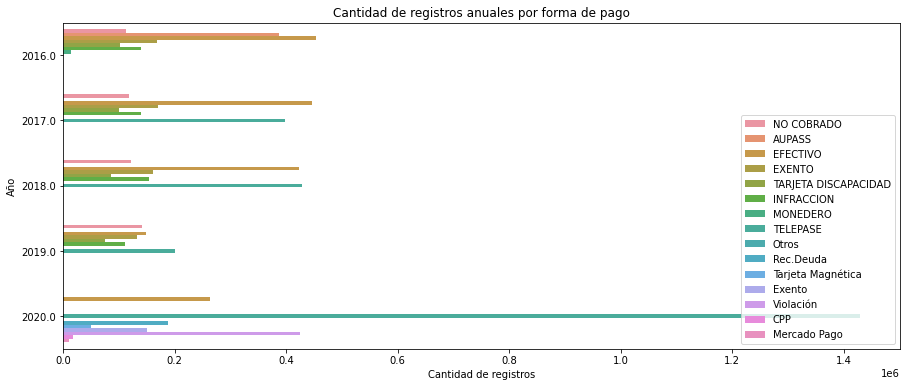

In [24]:
plt.figure(figsize=(15, 6))
sns.countplot(y=dataset_completo.periodo, hue=dataset_completo.forma_pago)
plt.title('Cantidad de registros anuales por forma de pago')
plt.ylabel('Año')
plt.xlabel('Cantidad de registros')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Agrupado por forma de pago
forma_pago = dataset_completo.groupby([dataset_completo.forma_pago, dataset_completo.periodo], as_index=False).sum()
forma_pago

,forma_pago,periodo,hora_inicio,cantidad_pasos,dia_fecha
0,AUPASS,2016.0,4510807.0,4.117583e+07,0.0
1,CPP,2020.0,205312.0,8.413790e+05,317770.0
2,EFECTIVO,2016.0,5392097.0,7.560062e+07,0.0
3,EFECTIVO,2017.0,5313337.0,6.950294e+07,0.0
4,EFECTIVO,2018.0,5018078.0,6.022552e+07,0.0
5,EFECTIVO,2019.0,1737568.0,5.362146e+07,0.0
6,EFECTIVO,2020.0,3162285.0,2.093427e+07,4144001.0
7,EXENTO,2016.0,2017465.0,1.472614e+06,0.0
8,EXENTO,2017.0,2031898.0,1.677497e+06,0.0
9,EXENTO,2018.0,1936409.0,1.250539e+06,0.0


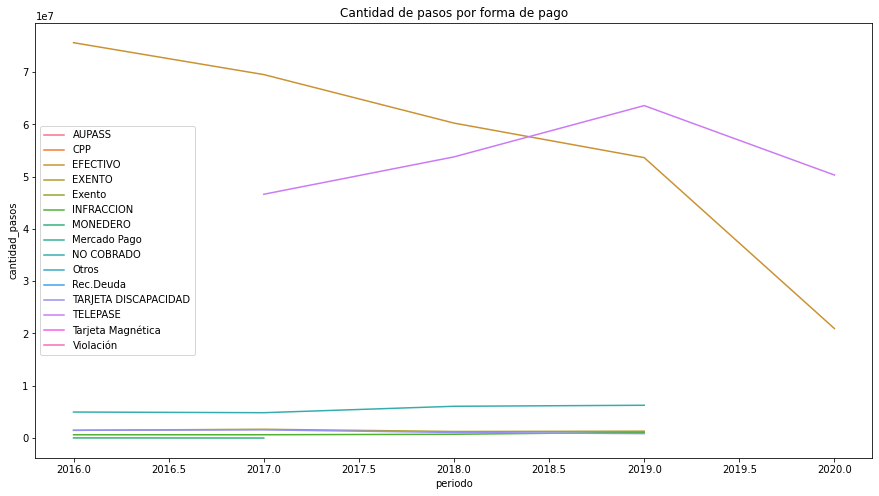

In [26]:
# Gráfico de las Formas de Pago
plt.figure(figsize=(15, 8))
sns.lineplot(x=forma_pago.periodo, y= forma_pago.cantidad_pasos, hue=forma_pago.forma_pago)
plt.title('Cantidad de pasos por forma de pago')
plt.legend(loc='best')
plt.show()

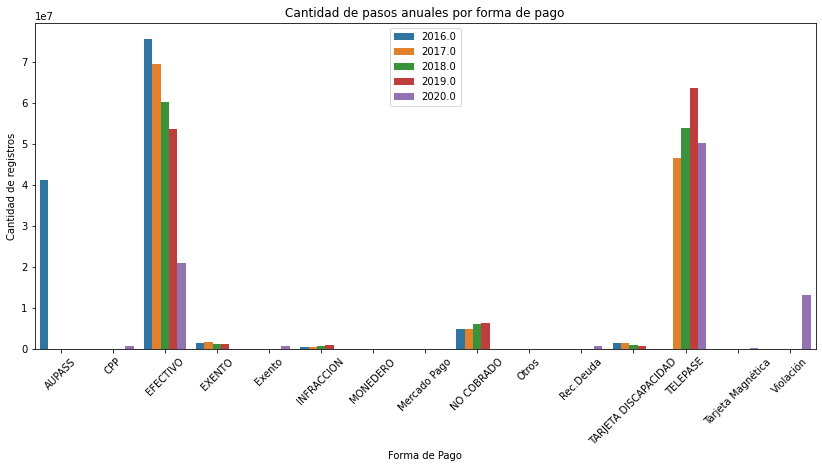

In [27]:
plt.figure(figsize=(14, 6))
sns.barplot(x=forma_pago.forma_pago, y=forma_pago.cantidad_pasos, hue=forma_pago.periodo)
plt.title('Cantidad de pasos anuales por forma de pago')
plt.xlabel('Forma de Pago')
plt.xticks(rotation=45)
plt.ylabel('Cantidad de registros')
plt.legend(loc='best')
plt.show()

**Formas de pago**: Podemos observar a simple vista que la forma de pago EFECTIVO desciende año a año, y la forma de pago TELEPASE pasa a ser la más utilizada con el correr de los años. 

**Circulación diaria**

In [28]:
dataset_completo.dia.value_counts()

Jueves       1143464
Miércoles    1142885
Viernes      1133249
Martes       1120510
Lunes        1088468
Sábado        967675
Domingo       877641
Name: dia, dtype: int64

In [29]:
# Dataset cantidad de datos por dia de semana. 
por_dia = dataset_completo.groupby(['dia']).sum()
# Ordenamos los valores del dataset por cantidad de pasos
por_dia = por_dia.sort_values(by='cantidad_pasos', ascending=False)
por_dia['cantidad_pasos']

dia
Viernes      9.516790e+07
Jueves       9.376483e+07
Miércoles    9.205741e+07
Martes       8.912347e+07
Lunes        8.449503e+07
Sábado       7.230289e+07
Domingo      6.028734e+07
Name: cantidad_pasos, dtype: float64

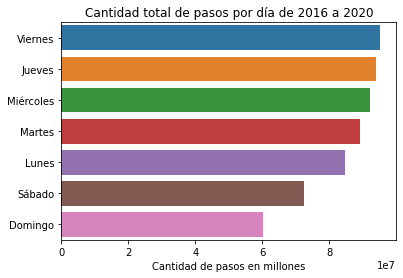

In [30]:
sns.barplot(x = por_dia.cantidad_pasos, y = por_dia.index.values)
plt.title('Cantidad total de pasos por día de 2016 a 2020')
plt.xlabel('Cantidad de pasos en millones')
plt.show()

**Circulación diaria**: Se observa que de Lunes a Viernes se concentra la mayor cantidad de pasos, siendo el Viernes el día de más circulación. El Sabado disminuye el tránsito, y el Domingo es el dia con menos tráfico vehicular. 

**Circulación horaria**:

In [31]:
hora = dataset_completo.groupby(dataset_completo.fecha.dt.hour).sum().sort_values('cantidad_pasos', ascending=False)
bold('Horarios con mayor circulación:')
hora.head(5)

Horarios con mayor circulación:


,periodo,hora_inicio,cantidad_pasos,dia_fecha
fecha,,,,
18,714203547.0,6015841.0,3.783210e+07,1938363.0
19,696072795.0,6208056.0,3.715433e+07,1859748.0
14,726163777.0,4677322.0,3.619451e+07,2018878.0
17,720489711.0,5711760.0,3.608587e+07,1978112.0
13,729829531.0,4339308.0,3.592887e+07,2046506.0


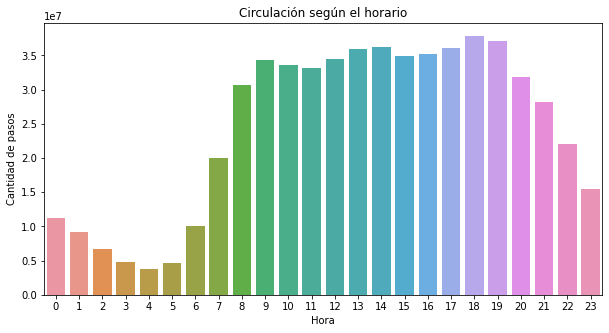

In [32]:
plt.figure(figsize=(10,5))
sns.barplot(y=hora.cantidad_pasos, x=hora.index.values)
plt.xlabel('Hora')
plt.ylabel('Cantidad de pasos')
plt.title('Circulación según el horario')
plt.show()

**Circulación horaria**: La mayor cantidad de pasos se observa de 8 a 21 horas, siendo las 18 el horario con mayor circulación.  

## Dataset Illia Efectivo

In [33]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
dataset_ill_ef = pd.DataFrame()
dataset_ill_ef = dataset_completo[
    (dataset_completo.estacion == 'ILLIA') &
    (dataset_completo.forma_pago =='EFECTIVO')
]
dataset_ill_ef

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,mes,dia_fecha,observacion,fecha
1700,2016.0,3.0,Viernes,ILLIA,Centro,Liviano,EFECTIVO,3.0,NaN,NaN,NaN,2016-01-01 04:00:00
1703,2016.0,3.0,Viernes,ILLIA,Centro,Liviano,EFECTIVO,446.0,NaN,NaN,NaN,2016-01-01 04:00:00
1708,2016.0,3.0,Viernes,ILLIA,Centro,Pesado,EFECTIVO,8.0,NaN,NaN,NaN,2016-01-01 04:00:00
1711,2016.0,4.0,Viernes,ILLIA,Centro,Liviano,EFECTIVO,10.0,NaN,NaN,NaN,2016-01-01 05:00:00
1712,2016.0,4.0,Viernes,ILLIA,Centro,Liviano,EFECTIVO,396.0,NaN,NaN,NaN,2016-01-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7472365,2020.0,11.0,Jueves,ILLIA,Provincia,Pesados 6 Ejes,EFECTIVO,1.0,diciembre,24.0,Efectivo,2020-12-24 12:00:00
7472376,2020.0,12.0,Jueves,ILLIA,Provincia,Pesados 6 Ejes,EFECTIVO,1.0,diciembre,24.0,Efectivo,2020-12-24 13:00:00
7472420,2020.0,17.0,Jueves,ILLIA,Centro,Pesados 6 Ejes,EFECTIVO,1.0,diciembre,24.0,Efectivo,2020-12-24 18:00:00
7473077,2020.0,12.0,Lunes,ILLIA,Provincia,Pesados 6 Ejes,EFECTIVO,1.0,diciembre,28.0,Efectivo,2020-12-28 13:00:00


### Diario

In [34]:
dataset_ill_ef_d = dataset_ill_ef.resample('D', on = 'fecha').sum()
dataset_ill_ef_d

,periodo,hora_inicio,cantidad_pasos,dia_fecha
fecha,,,,
2016-01-01,409248.0,2671.0,25602.0,0.0
2016-01-02,510048.0,2923.0,36136.0,0.0
2016-01-03,514080.0,3099.0,37225.0,0.0
2016-01-04,566496.0,3316.0,50312.0,0.0
2016-01-05,562464.0,3401.0,49907.0,0.0
...,...,...,...,...
2020-12-27,311080.0,1815.0,8434.0,4158.0
2020-12-28,307040.0,1775.0,10311.0,4256.0
2020-12-29,345420.0,2057.0,12036.0,4959.0


In [35]:
#Quitamos las columnas que no vamos a utilizar
dataset_ill_ef_d.drop(columns = ['periodo','hora_inicio','dia_fecha'], inplace = True)
dataset_ill_ef_d

,cantidad_pasos
fecha,
2016-01-01,25602.0
2016-01-02,36136.0
2016-01-03,37225.0
2016-01-04,50312.0
2016-01-05,49907.0
...,...
2020-12-27,8434.0
2020-12-28,10311.0
2020-12-29,12036.0


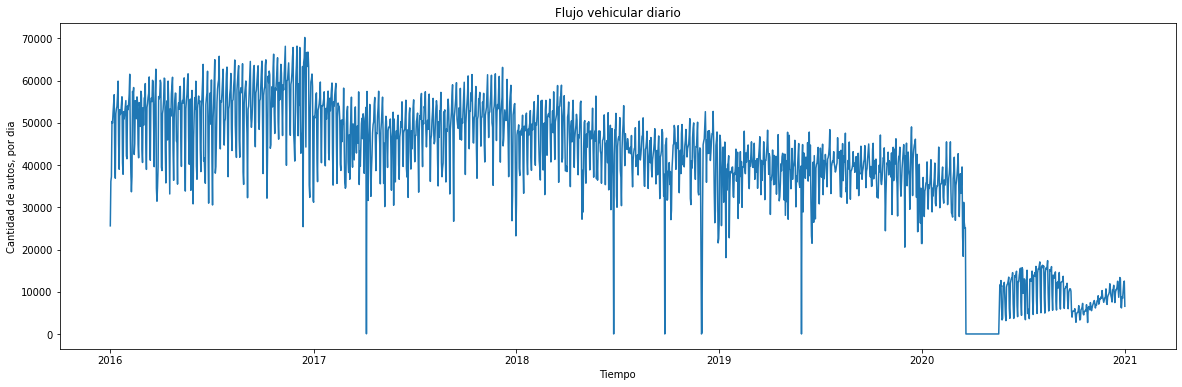

In [36]:
plt.figure(figsize = (20,6))
plt.plot(dataset_ill_ef_d.index, dataset_ill_ef_d.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Flujo vehicular diario')
plt.show()

#### Outliers diario

Text(0.5, 1.0, 'Boxplot cantidad de pasos diarios')

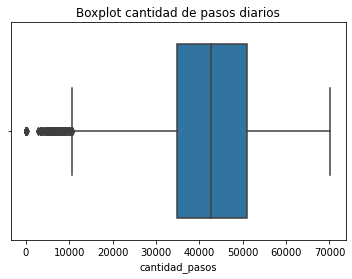

In [37]:
# OUTLIERS
sns.boxplot(dataset_ill_ef_d.cantidad_pasos)
plt.title('Boxplot cantidad de pasos diarios')

In [38]:
# Valores faltantes
dataset_ill_ef_d.isna().sum()

cantidad_pasos    0
dtype: int64

No se encuentran valores faltantes

#### Exploración de datos

In [39]:
bold('Datos estadísticos del dataset Illia')
dataset_ill_ef_d.describe()

Datos estadísticos del dataset Illia


,cantidad_pasos
count,1827.000000
mean,39392.113300
std,16361.654866
min,0.000000
25%,34829.500000
50%,42592.000000
75%,50951.500000
max,70203.000000


In [40]:
#10 Días de menor flujo vehicular: 
bold('10 Días de menor flujo vehicular:')
dataset_ill_ef_d.sort_values('cantidad_pasos', ascending=True).head(10)

10 Días de menor flujo vehicular:


,cantidad_pasos
fecha,
2020-03-28,0.0
2020-05-01,0.0
2020-05-02,0.0
2020-05-03,0.0
2020-05-04,0.0
2020-05-05,0.0
2020-05-06,0.0
2020-05-07,0.0
2020-05-08,0.0


In [41]:
#10 Días de mayor flujo vehicular: 
bold('10 Días de mayor flujo vehicular:')
dataset_ill_ef_d.sort_values('cantidad_pasos', ascending=False).head(10)

10 Días de mayor flujo vehicular:


,cantidad_pasos
fecha,
2016-12-16,70203.0
2016-12-02,68158.0
2016-11-11,68121.0
2016-11-25,67836.0
2016-12-07,67835.0
2016-12-22,66715.0
2016-12-21,66673.0
2016-12-19,66649.0
2016-10-21,66244.0


#### Descomposición

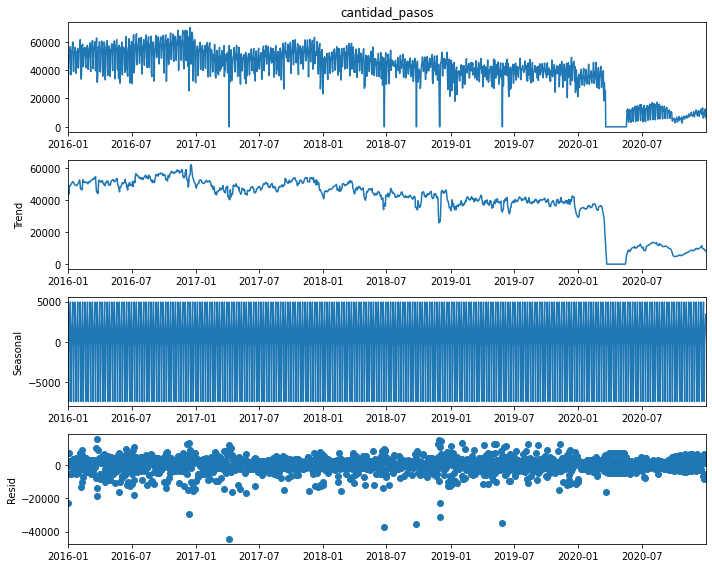

In [42]:
decomp_ef_d = tsa.seasonal.seasonal_decompose(
    dataset_ill_ef_d.cantidad_pasos, model='additive', extrapolate_trend='freq'
)
plt.rcParams['figure.figsize'] = [10,8]
decomp_ef_d.plot()
plt.show()

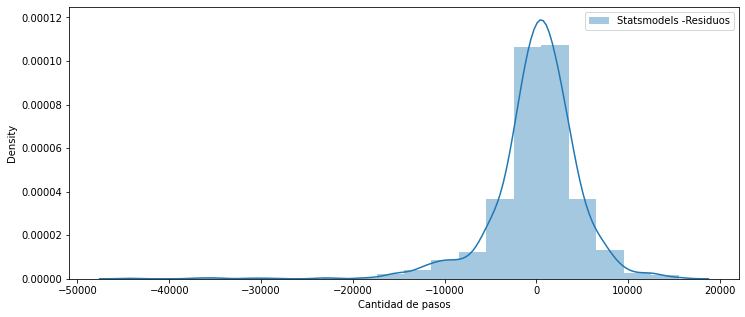

In [43]:
# Histográma de valores residuales
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_ef_d.resid, bins=20, label="Statsmodels -Residuos")
plt.xlabel('Cantidad de pasos')
plt.legend()
plt.show()

### Semanal (media)

In [44]:
dataset_ill_ef_s = dataset_ill_ef_d.resample('W').mean()
dataset_ill_ef_s

,cantidad_pasos
fecha,
2016-01-03,32987.666667
2016-01-10,48885.857143
2016-01-17,51378.428571
2016-01-24,49459.571429
2016-01-31,49745.857143
...,...
2020-12-06,9797.142857
2020-12-13,9347.857143
2020-12-20,10511.142857


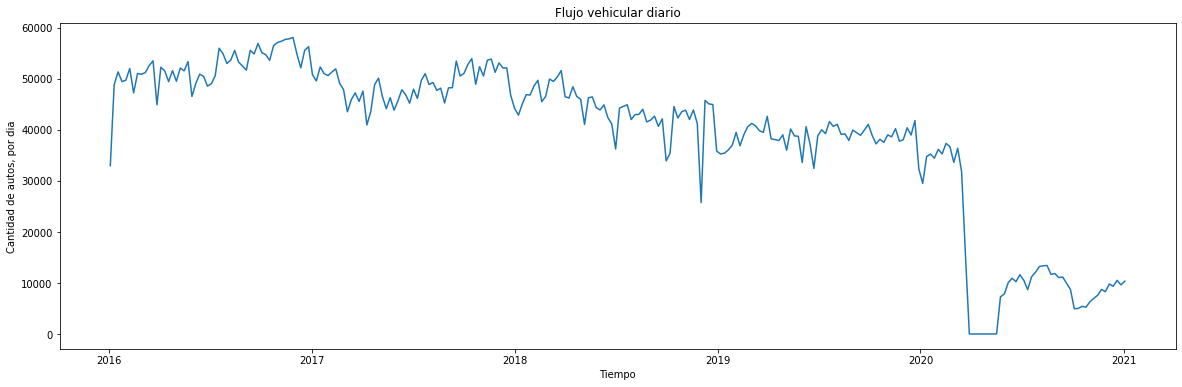

In [45]:
plt.figure(figsize = (20,6))
plt.plot(dataset_ill_ef_s.index, dataset_ill_ef_s.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Flujo vehicular diario')
plt.show()

#### Outliers semanal

Text(0.5, 1.0, 'Boxplot cantidad de pasos semanal')

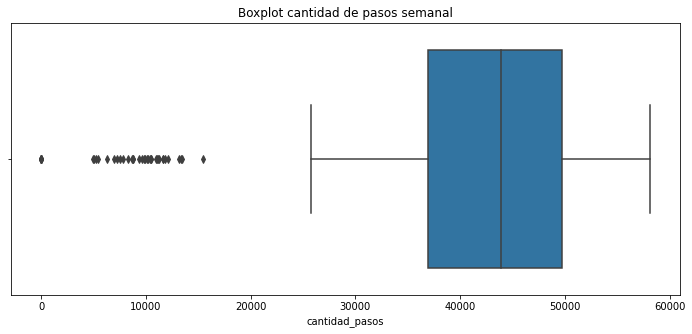

In [46]:
# OUTLIERS semanal Illia|Efectivo
plt.figure(figsize=(12,5))
sns.boxplot(dataset_ill_ef_s.cantidad_pasos)
plt.title('Boxplot cantidad de pasos semanal')

[Text(0.5, 0, '')]

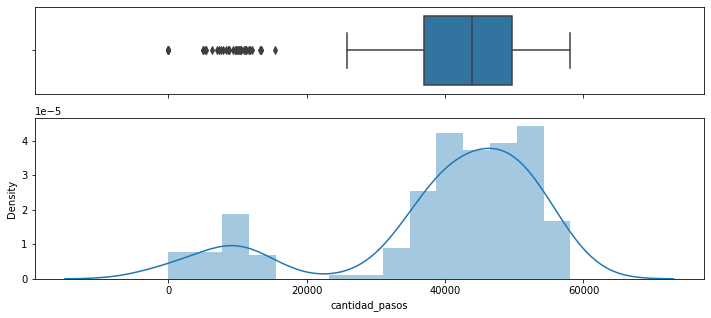

In [47]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.35, .65)}) 
sns.boxplot(dataset_ill_ef_s.cantidad_pasos, ax=ax_box)
sns.distplot(dataset_ill_ef_s.cantidad_pasos, ax=ax_hist) 
# Remuevo el eje x del boxplot
ax_box.set(xlabel='')

Los valores atípicos corresponden a las semanas especiales de 2020

In [48]:
# Valores faltantes
dataset_ill_ef_s.isna().sum()

cantidad_pasos    0
dtype: int64

No se encuentran valores faltantes

#### Exploración de datos

In [49]:
#10 semanas de menor flujo vehicular: 
bold('10 semanas de menor flujo vehicular:')
dataset_ill_ef_s.sort_values('cantidad_pasos', ascending=True).head(10)

10 semanas de menor flujo vehicular:


,cantidad_pasos
fecha,
2020-03-29,0.000000
2020-05-03,0.000000
2020-04-26,0.000000
2020-04-19,0.000000
2020-04-12,0.000000
2020-04-05,0.000000
2020-05-10,0.000000
2020-05-17,0.142857
2020-10-04,4940.428571


Las 10 semanas de menor flujo vehicular con pago **en efectivo** corresponden al año 2020, cuando se prohibió la circulación por la pandemia. 

In [50]:
#10 semanas de mayor flujo vehicular: 
bold('10 semanas de mayor flujo vehicular:')
dataset_ill_ef_s.sort_values('cantidad_pasos', ascending=False).head(10)

10 semanas de mayor flujo vehicular:


,cantidad_pasos
fecha,
2016-11-27,58119.571429
2016-11-20,57847.428571
2016-11-13,57738.000000
2016-11-06,57371.000000
2016-10-30,57130.571429
2016-09-25,56933.142857
2016-10-23,56525.714286
2016-12-25,56308.000000
2016-07-17,56011.142857


Las 10 semanas de mayor flujo vehicular con pago **en efectivo** corresponden al año 2016, y en su mayoría son del 4to trimestre. 

#### Descomposición


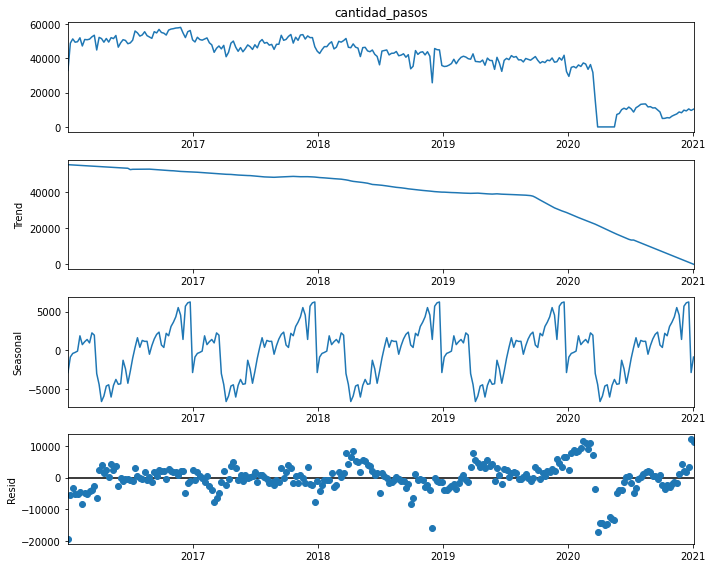

In [51]:
decomp_ef_s = tsa.seasonal.seasonal_decompose(
    dataset_ill_ef_s.cantidad_pasos, model='additive', extrapolate_trend='freq'
)
plt.rcParams['figure.figsize'] = [10,8]
decomp_ef_s.plot()
plt.show()

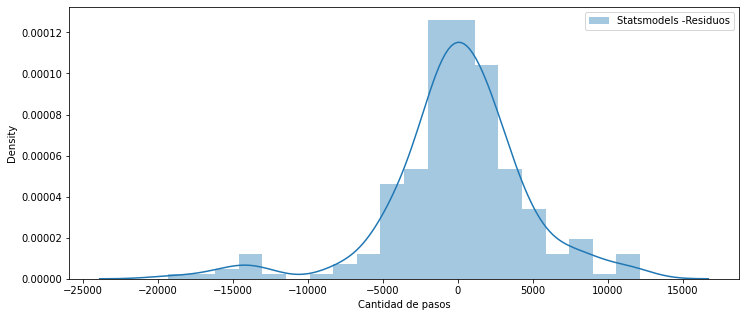

In [52]:
# Histográma de valores residuales
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_ef_s.resid, bins=20, label="Statsmodels -Residuos")
plt.xlabel('Cantidad de pasos')
plt.legend()
plt.show()

## Dataset Illia todos los medios de pago

In [53]:
#Nos quedamos solamente con la estación Illia y todas las formas de pago
dataset_ill = pd.DataFrame()
dataset_ill = dataset_completo[
    (dataset_completo.estacion == 'ILLIA')
]
dataset_ill

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,mes,dia_fecha,observacion,fecha
1690,2016.0,0.0,Viernes,ILLIA,Centro,Liviano,NO COBRADO,156.0,NaN,NaN,NaN,2016-01-01 01:00:00
1691,2016.0,0.0,Viernes,ILLIA,Centro,Liviano,AUPASS,57.0,NaN,NaN,NaN,2016-01-01 01:00:00
1692,2016.0,1.0,Viernes,ILLIA,Centro,Liviano,NO COBRADO,763.0,NaN,NaN,NaN,2016-01-01 02:00:00
1693,2016.0,1.0,Viernes,ILLIA,Centro,Liviano,AUPASS,287.0,NaN,NaN,NaN,2016-01-01 02:00:00
1694,2016.0,1.0,Viernes,ILLIA,Centro,Pesado,AUPASS,3.0,NaN,NaN,NaN,2016-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7473703,2020.0,17.0,Miércoles,ILLIA,Centro,Pesados 6 Ejes,TELEPASE,1.0,diciembre,30.0,Tag - PosPago OCR,2020-12-30 18:00:00
7473745,2020.0,21.0,Miércoles,ILLIA,Centro,Pesados 6 Ejes,TELEPASE,1.0,diciembre,30.0,Tag - PosPago,2020-12-30 22:00:00
7473801,2020.0,9.0,Jueves,ILLIA,Provincia,Pesados 6 Ejes,TELEPASE,1.0,diciembre,31.0,Tag - PosPago OCR,2020-12-31 10:00:00
7473813,2020.0,10.0,Jueves,ILLIA,Provincia,Pesados 6 Ejes,TELEPASE,2.0,diciembre,31.0,Tag - PosPago,2020-12-31 11:00:00


### Diario

In [54]:
dataset_ill_d = dataset_ill.resample('D', on = 'fecha').sum()
dataset_ill_d

,periodo,hora_inicio,cantidad_pasos,dia_fecha
fecha,,,,
2016-01-01,1187424.0,7587.0,37975.0,0.0
2016-01-02,1457568.0,8572.0,49483.0,0.0
2016-01-03,1393056.0,8273.0,50502.0,0.0
2016-01-04,1681344.0,9854.0,88914.0,0.0
2016-01-05,1695456.0,10283.0,89811.0,0.0
...,...,...,...,...
2020-12-27,1725080.0,10382.0,39616.0,23058.0
2020-12-28,2110900.0,12544.0,71737.0,29260.0
2020-12-29,2274520.0,13631.0,79839.0,32654.0


In [55]:
#Quitamos las columnas que no vamos a utilizar
dataset_ill_d.drop(columns = ['periodo','hora_inicio','dia_fecha'], inplace = True)
dataset_ill_d

,cantidad_pasos
fecha,
2016-01-01,37975.0
2016-01-02,49483.0
2016-01-03,50502.0
2016-01-04,88914.0
2016-01-05,89811.0
...,...
2020-12-27,39616.0
2020-12-28,71737.0
2020-12-29,79839.0


Obtenemos un dataset de 1827 filas (dias)

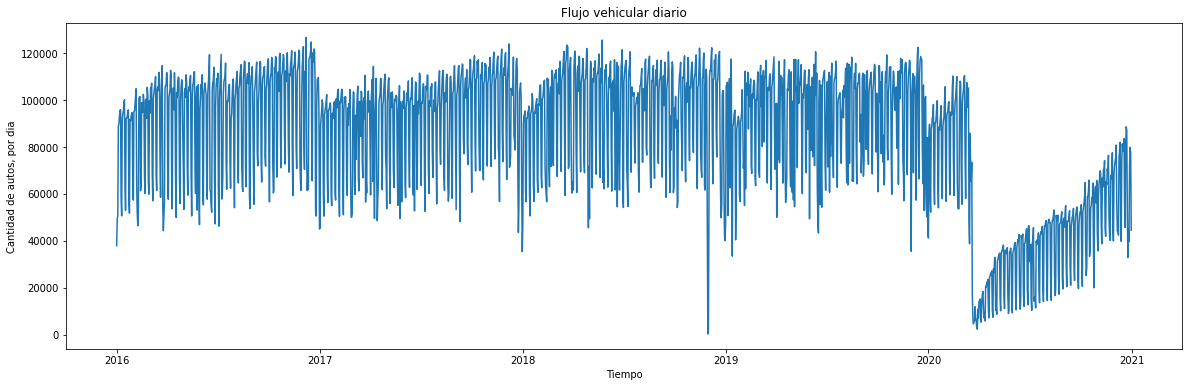

In [56]:
plt.figure(figsize = (20,6))
plt.plot(dataset_ill_d.index, dataset_ill_d.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Flujo vehicular diario')
plt.show()

#### Outliers diario

Text(0.5, 1.0, 'Boxplot cantidad de pasos diarios')

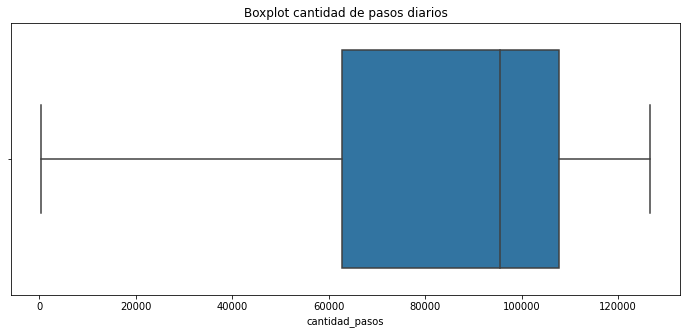

In [57]:
# OUTLIERS
sns.boxplot(dataset_ill_d.cantidad_pasos)
plt.title('Boxplot cantidad de pasos diarios')

In [58]:
# Valores faltantes
dataset_ill_d.isna().sum()

cantidad_pasos    0
dtype: int64

No se encuentran valores faltantes

#### Exploración de datos

In [59]:
bold('Datos estadísticos del dataset Illia')
dataset_ill_d.describe()

Datos estadísticos del dataset Illia


,cantidad_pasos
count,1827.000000
mean,84346.202518
std,28719.237470
min,387.000000
25%,62671.500000
50%,95579.000000
75%,107855.500000
max,126609.000000


In [60]:
#10 Días de menor flujo vehicular: 
bold('10 Días de menor flujo vehicular:')
dataset_ill_d.sort_values('cantidad_pasos', ascending=True).head(10)

10 Días de menor flujo vehicular:


,cantidad_pasos
fecha,
2018-11-30,387.0
2018-12-01,1121.0
2020-03-29,2419.0
2020-03-28,2848.0
2020-03-22,4688.0
2020-04-05,5384.0
2020-03-24,5834.0
2020-04-12,5910.0
2020-03-23,5975.0


In [61]:
#10 Días de mayor flujo vehicular: 
bold('10 Días de mayor flujo vehicular:')
dataset_ill_d.sort_values('cantidad_pasos', ascending=False).head(10)

10 Días de mayor flujo vehicular:


,cantidad_pasos
fecha,
2016-12-07,126609.0
2018-05-24,125519.0
2016-12-16,124668.0
2017-12-07,123854.0
2018-03-21,123380.0
2018-03-22,122955.0
2016-12-02,122713.0
2018-03-23,122528.0
2019-12-13,122390.0


#### Descomposición

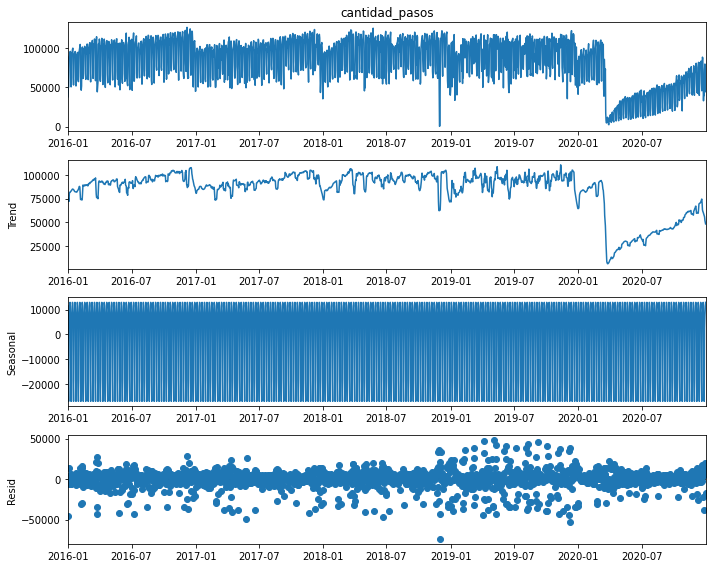

In [62]:
decomp_d = tsa.seasonal.seasonal_decompose(
    dataset_ill_d.cantidad_pasos, model='additive', extrapolate_trend='freq'
)
plt.rcParams['figure.figsize'] = [10,8]
decomp_d.plot()
plt.show()

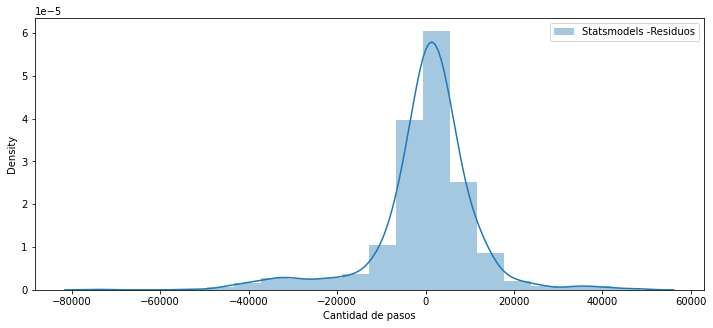

In [63]:
# Histográma de valores residuales
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_d.resid, bins=20, label="Statsmodels -Residuos")
plt.xlabel('Cantidad de pasos')
plt.legend()
plt.show()

### Semanal (media)

In [64]:
dataset_ill_s = dataset_ill_d.resample('W').mean()
dataset_ill_s

,cantidad_pasos
fecha,
2016-01-03,45986.666667
2016-01-10,81708.285714
2016-01-17,85108.285714
2016-01-24,82394.285714
2016-01-31,83124.285714
...,...
2020-12-06,67146.285714
2020-12-13,59633.428571
2020-12-20,71326.142857


Obtenemos un dataset de 262 filas (semanas)

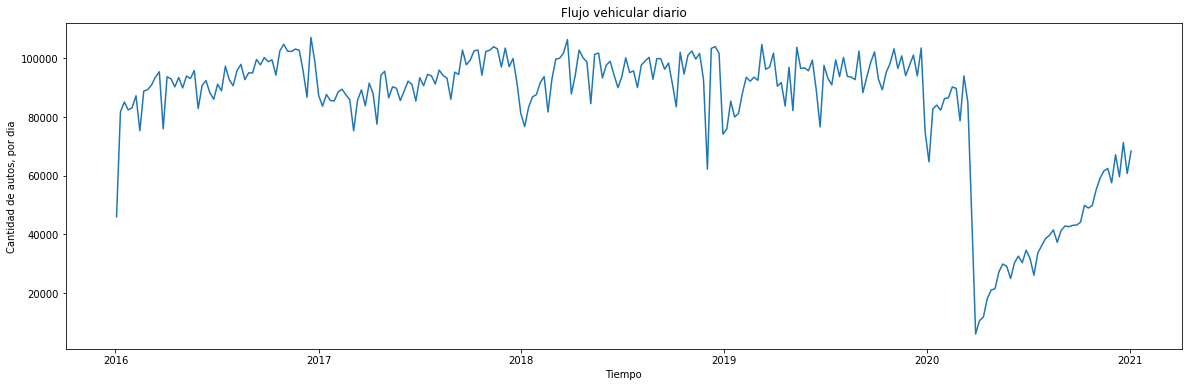

In [65]:
plt.figure(figsize = (20,6))
plt.plot(dataset_ill_s.index, dataset_ill_s.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Flujo vehicular diario')
plt.show()

####Outliers semanal

Text(0.5, 1.0, 'Boxplot cantidad de pasos semanal')

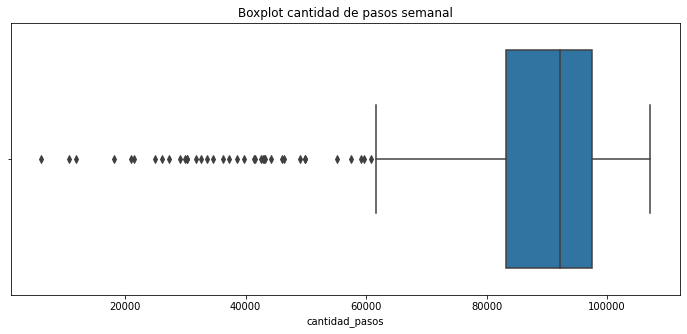

In [66]:
# OUTLIERS Semanal Illia completo
plt.figure(figsize=(12,5))
sns.boxplot(dataset_ill_s.cantidad_pasos)
plt.title('Boxplot cantidad de pasos semanal')

[Text(0.5, 0, '')]

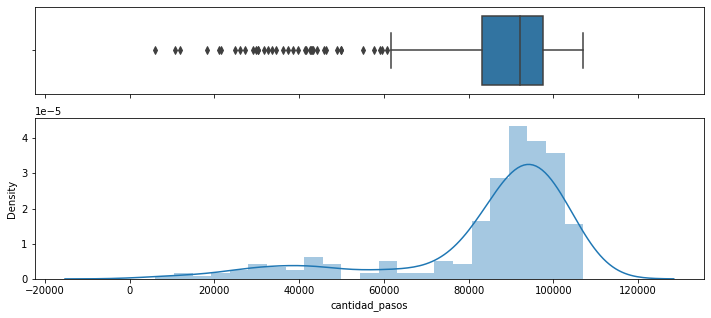

In [67]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.35, .65)}) 
sns.boxplot(dataset_ill_s.cantidad_pasos, ax=ax_box)
sns.distplot(dataset_ill_s.cantidad_pasos, ax=ax_hist) 
# Remuevo el eje x del boxplot
ax_box.set(xlabel='')

Los valores atípicos corresponden a las semanas especiales de 2020

In [68]:
# Valores faltantes
dataset_ill_s.isna().sum()

cantidad_pasos    0
dtype: int64

No se encuentran valores faltantes

#### Exploración de datos

In [69]:
bold('Datos estadísticos del dataset Illia')
dataset_ill_s.describe()

Datos estadísticos del dataset Illia


,cantidad_pasos
count,262.000000
mean,84236.451836
std,21688.864912
min,6084.000000
25%,83167.142857
50%,92199.357143
75%,97562.607143
max,107083.285714


In [70]:
#10 semanas de menor flujo vehicular: 
bold('10 semanas de menor flujo vehicular:')
dataset_ill_s.sort_values('cantidad_pasos', ascending=True).head(10)

10 semanas de menor flujo vehicular:


,cantidad_pasos
fecha,
2020-03-29,6084.000000
2020-04-05,10635.714286
2020-04-12,11843.142857
2020-04-19,18140.571429
2020-04-26,21044.142857
2020-05-03,21526.000000
2020-05-31,24967.000000
2020-07-12,26083.571429
2020-05-10,27290.714286


In [71]:
#10 semanas de mayor flujo vehicular: 
bold('10 semanas de mayor flujo vehicular:')
dataset_ill_s.sort_values('cantidad_pasos', ascending=False).head(10)

10 semanas de mayor flujo vehicular:


,cantidad_pasos
fecha,
2016-12-18,107083.285714
2018-03-25,106351.428571
2016-10-30,104761.571429
2019-03-10,104700.857143
2018-12-16,103969.857143
2017-11-12,103934.857143
2019-05-12,103738.571429
2019-12-22,103499.571429
2017-12-03,103471.857143


#### Descomposición

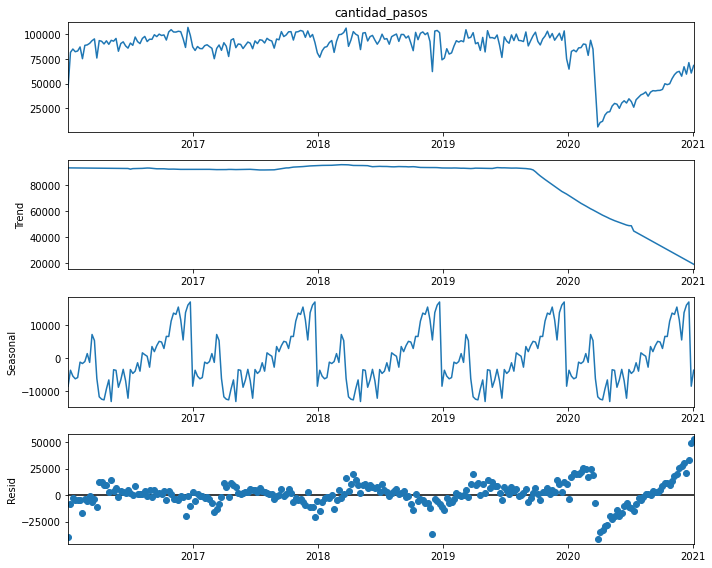

In [72]:
decomp_s = tsa.seasonal.seasonal_decompose(
    dataset_ill_s.cantidad_pasos, model='additive', extrapolate_trend='freq'
)
plt.rcParams['figure.figsize'] = [10,8]
decomp_s.plot()
plt.show()

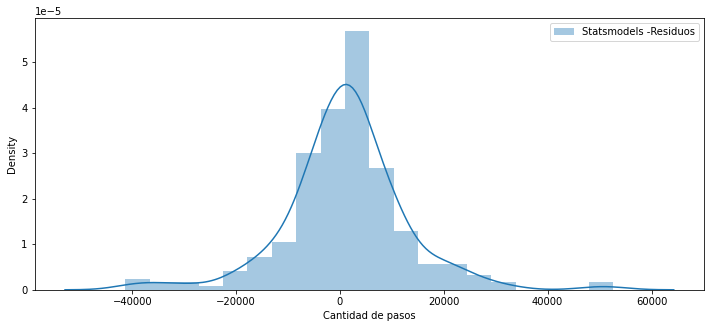

In [73]:
# Histográma de valores residuales
plt.rcParams['figure.figsize'] = [12,5]
sns.distplot(decomp_s.resid, bins=20, label="Statsmodels -Residuos")
plt.xlabel('Cantidad de pasos')
plt.legend()
plt.show()

## Conclusiones de Análisis Exploratorio

Los datos fueron explotados, analizados y preparados para aplicarles los modelos de predicción seleccionados. 

De la información recolectada podemos concluir que los datos en general para la forma de pago en efectivo, tienen una tendencia descendiente. 

La información recolectada para el año 2020 nos muestra que fue un año atípico, por restricciones de transitar debido a la cuarentena producto del virus COVID 19. Luego un descendo bruzco relacionado con una decisión gubernamental de evitar el intercambio de dinero en efectivo, al punto de reemplazarlo totalmente por el pago Tag o Telepase. 

Por estas razónes es que vamos a utilizar los modelos de predicción para obtener los valores del 4to trimeste de 2019, y del 1er trimestre del 2020, hasta donde los valores son relativamente normales. 

[Link de referencia](https://www.telam.com.ar/notas/202008/500766-eliminan-el-pago-en-efectivo-en-las-cabinas-de-peaje-desde-el-28-de-agosto.html)

# Predicciones | Forecasting

OBJETIVOS: 


1.   4to trimestre 2019
  - Train: 2016 hasta 3er trimestre 2019
2.   1er trimestre 2020
  - Train: 2016 hasta fin de 2019 



# 1- Predicción 4to trimestre 2019

## Illia Efectivo | Semanal




### Train Test split

In [74]:
# Train y test para objetivo 1
dt_ef = dataset_ill_ef_s['2016-01-03':'2019-12-31']
train_ef = dataset_ill_ef_s['2016-01-03':'2019-10-12']
print(bold('Train Illia Efectivo: '), train_ef, '\n')
test_ef = dataset_ill_ef_s['2019-10-13':'2019-12-31']
print(bold('Test Illia Efectivo: '), test_ef)

Train Illia Efectivo: 
None             cantidad_pasos
fecha                     
2016-01-03    32987.666667
2016-01-10    48885.857143
2016-01-17    51378.428571
2016-01-24    49459.571429
2016-01-31    49745.857143
...                    ...
2019-09-08    39467.285714
2019-09-15    38941.714286
2019-09-22    39989.571429
2019-09-29    41081.142857
2019-10-06    38926.142857

[197 rows x 1 columns] 

Test Illia Efectivo: 
None             cantidad_pasos
fecha                     
2019-10-13    37262.857143
2019-10-20    38163.857143
2019-10-27    37564.285714
2019-11-03    39018.428571
2019-11-10    38648.000000
2019-11-17    40255.714286
2019-11-24    37785.714286
2019-12-01    38079.285714
2019-12-08    40413.000000
2019-12-15    38994.285714
2019-12-22    41840.142857
2019-12-29    32341.428571


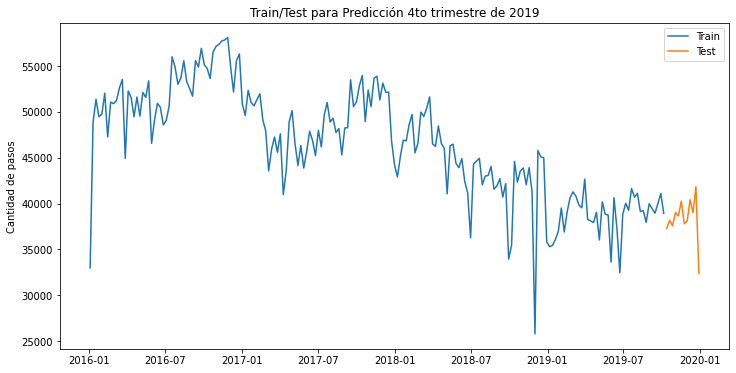

In [75]:
# Gráfico Train Test Semanal Illia|Efectivo
# ==============================================================================
plt.figure(figsize=(12,6))
plt.plot(train_ef, label='Train')
plt.plot(test_ef, label='Test')
plt.title('Train/Test para Predicción 4to trimestre de 2019')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

### Benchmark

Vamos a utilizar el mejor modelo del trabajo anterior, que fue el Random Forest Regressor de la librería SKForecast

In [76]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=16)

forecaster_rf.fit(y=train_ef.cantidad_pasos)
forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=42)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

In [77]:
# Predicciones
# ==============================================================================
steps = 12
pred_bench_ef = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
pred_bench_ef = pd.Series(data=pred_bench_ef, index=test_ef.index)
predicciones_ef = test_ef.copy()
predicciones_ef['Benchmark'] = pred_bench_ef
predicciones_ef

,cantidad_pasos,Benchmark
fecha,,
2019-10-13,37262.857143,38462.308571
2019-10-20,38163.857143,38777.280000
2019-10-27,37564.285714,37595.317143
2019-11-03,39018.428571,38738.038571
2019-11-10,38648.000000,38716.650000
2019-11-17,40255.714286,38951.967143
2019-11-24,37785.714286,39243.161429
2019-12-01,38079.285714,39343.897143
2019-12-08,40413.000000,39514.430000


In [78]:
# Error Random Forest Regressor
# ==============================================================================
rmse_bench = np.sqrt(mean_squared_error(y_true = test_ef[:], y_pred = pred_bench_ef))
print(f"Error de test Benchmark (rmse): {rmse_bench}")

Error de test Benchmark (rmse): 2299.314608398829


### Prophet

Prophet es una herramienta de Facebook considerada una alternativa a los modelos ARIMA, que tiene un buen desempeño cuando los datos tienen fuertes efectos estacionales y varias temporadas de datos históricos para trabajar. 

Las especificaciones de la herramienta se encuentran en la web oficial de [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Las columnas de datos deben llamarse específicamente 'ds' e 'y'

In [79]:
# Adecuación del dataset para Prophet.
train_pr = train_ef.reset_index()
test_pr = test_ef.reset_index() 

In [80]:
# Cambiamos los nombres de las columnas
train_pr.columns = ['ds', 'y']
test_pr.columns = ['ds', 'y']
# Cantidad de semanas a predecir
nobs = len(test_pr.y)

print(train_pr.head(3))
print(test_pr.head(3))
print('\nSemanas datatest: ', len(train_pr.y)+len(test_pr.y))
print('Semanas train: ', len(train_pr.y))
print('Semanas a predecir: ', nobs)

          ds             y
0 2016-01-03  32987.666667
1 2016-01-10  48885.857143
2 2016-01-17  51378.428571
          ds             y
0 2019-10-13  37262.857143
1 2019-10-20  38163.857143
2 2019-10-27  37564.285714

Semanas datatest:  209
Semanas train:  197
Semanas a predecir:  12


In [81]:
# Comprobamos que la columna ds sea del typo DateTime
print(train_pr.info())
print(test_pr.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      197 non-null    datetime64[ns]
 1   y       197 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      12 non-null     datetime64[ns]
 1   y       12 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 320.0 bytes
None


In [82]:
# Creamos una instancia del modelo Prophet
prophet_ef = Prophet()
# Entrenamos el modelo con el train
prophet_ef.fit(train_pr)

2021-11-20 21:09:02,287 fbprophet  INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2021-11-20 21:09:02,288 fbprophet  INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [83]:
# Creamos un almacen de predicciones
futuro = prophet_ef.make_future_dataframe(periods=nobs, freq='W')
futuro

,ds
0,2016-01-03
1,2016-01-10
2,2016-01-17
3,2016-01-24
4,2016-01-31
...,...
204,2019-12-01
205,2019-12-08
206,2019-12-15
207,2019-12-22


In [84]:
# Incluimos los pronósticos en el almacen
pronostico_pr_ef = prophet_ef.predict(futuro)
pronostico_pr_ef

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-03,51749.189319,44368.694515,51806.753093,51749.189319,51749.189319,-3756.718825,-3756.718825,-3756.718825,-3756.718825,-3756.718825,-3756.718825,0.0,0.0,0.0,47992.470494
1,2016-01-10,51760.039848,43316.695596,51030.785483,51760.039848,51760.039848,-4569.268675,-4569.268675,-4569.268675,-4569.268675,-4569.268675,-4569.268675,0.0,0.0,0.0,47190.771173
2,2016-01-17,51770.890377,44663.160308,52645.528307,51770.890377,51770.890377,-3077.763935,-3077.763935,-3077.763935,-3077.763935,-3077.763935,-3077.763935,0.0,0.0,0.0,48693.126442
3,2016-01-24,51781.740905,47053.624547,54826.505852,51781.740905,51781.740905,-918.135608,-918.135608,-918.135608,-918.135608,-918.135608,-918.135608,0.0,0.0,0.0,50863.605298
4,2016-01-31,51792.591434,47963.647155,55793.726176,51792.591434,51792.591434,138.719133,138.719133,138.719133,138.719133,138.719133,138.719133,0.0,0.0,0.0,51931.310568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2019-12-01,36349.623177,34306.387050,42099.420642,36312.106328,36381.014115,1782.899286,1782.899286,1782.899286,1782.899286,1782.899286,1782.899286,0.0,0.0,0.0,38132.522463
205,2019-12-08,36249.569596,35225.869918,42910.829076,36201.190332,36290.028311,2865.055060,2865.055060,2865.055060,2865.055060,2865.055060,2865.055060,0.0,0.0,0.0,39114.624656
206,2019-12-15,36149.516014,35414.295709,43431.207623,36092.862717,36196.235004,3204.793537,3204.793537,3204.793537,3204.793537,3204.793537,3204.793537,0.0,0.0,0.0,39354.309552
207,2019-12-22,36049.462433,33480.460097,41226.007568,35980.514726,36106.535214,1429.230855,1429.230855,1429.230855,1429.230855,1429.230855,1429.230855,0.0,0.0,0.0,37478.693288


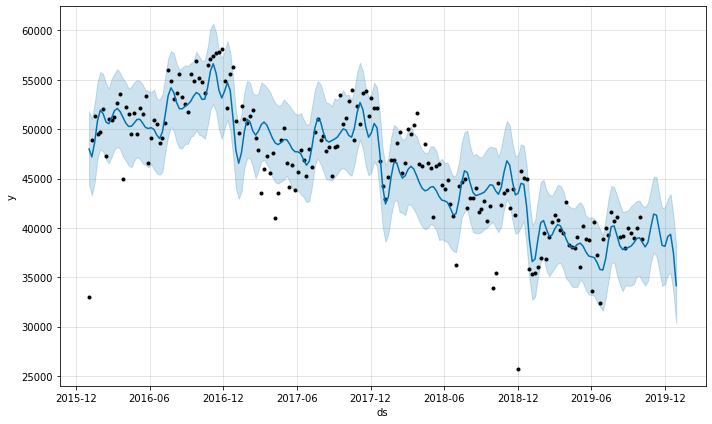

In [85]:
fig1 = prophet_ef.plot(pronostico_pr_ef)

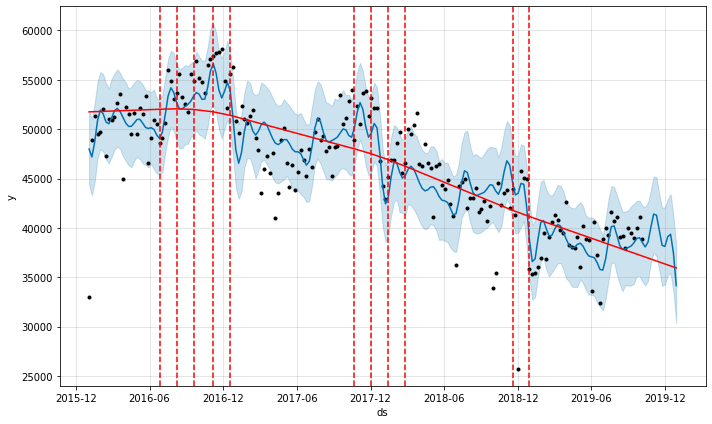

In [86]:
# Gráfico con puntos de cambio de tendencia
fig1 = prophet_ef.plot(pronostico_pr_ef)
a = add_changepoints_to_plot(fig1.gca(), prophet_ef, pronostico_pr_ef)

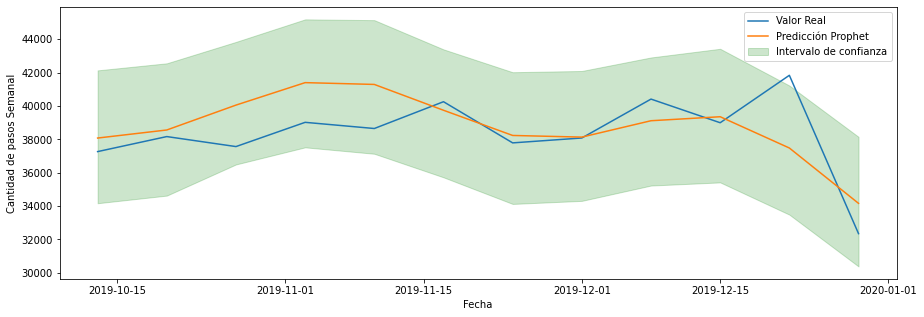

In [87]:
# Gráfico pronóstico Prophet vs Real
plt.figure(figsize = (15,5))
plt.plot(test_pr.ds, test_pr.y, label = 'Valor Real')
plt.plot(test_pr.ds, pronostico_pr_ef.yhat[-nobs:], label = 'Predicción Prophet')
plt.fill_between(test_pr.ds, pronostico_pr_ef.yhat_upper[-nobs:], pronostico_pr_ef.yhat_lower[-nobs:], alpha=0.2, color ='g', label='Intervalo de confianza')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Semanal')
plt.legend()
plt.show()

In [88]:
# Error RMSE nobs = 12
y_pred = pronostico_pr_ef.iloc[-nobs:]['yhat']
y_true = test_pr['y']
rmse_prop_ef = rmse(y_pred, y_true)
print("Error de test Prophet (RMSE):", rmse_prop_ef)

Error de test Prophet (RMSE): 1920.8180972289576


In [89]:
pronostico_pr_ef.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
197,2019-10-13,37049.998245,34164.759284,42136.428714,37049.998245,37049.998245,1025.833174,1025.833174,1025.833174,1025.833174,1025.833174,1025.833174,0.0,0.0,0.0,38075.831419
198,2019-10-20,36949.944664,34622.442721,42559.739142,36949.850503,36950.224359,1609.316568,1609.316568,1609.316568,1609.316568,1609.316568,1609.316568,0.0,0.0,0.0,38559.261232
199,2019-10-27,36849.891083,36491.541257,43843.916607,36847.242299,36853.764934,3202.395371,3202.395371,3202.395371,3202.395371,3202.395371,3202.395371,0.0,0.0,0.0,40052.286453
200,2019-11-03,36749.837501,37517.937087,45196.521867,36742.483024,36757.862572,4650.519053,4650.519053,4650.519053,4650.519053,4650.519053,4650.519053,0.0,0.0,0.0,41400.356555
201,2019-11-10,36649.783920,37132.530762,45149.496205,36636.544723,36662.625031,4642.371578,4642.371578,4642.371578,4642.371578,4642.371578,4642.371578,0.0,0.0,0.0,41292.155498
202,2019-11-17,36549.730339,35719.743202,43395.899965,36530.749933,36567.555066,3193.416845,3193.416845,3193.416845,3193.416845,3193.416845,3193.416845,0.0,0.0,0.0,39743.147184
203,2019-11-24,36449.676758,34122.199670,42026.273410,36421.692423,36474.967329,1781.476243,1781.476243,1781.476243,1781.476243,1781.476243,1781.476243,0.0,0.0,0.0,38231.153001
204,2019-12-01,36349.623177,34306.387050,42099.420642,36312.106328,36381.014115,1782.899286,1782.899286,1782.899286,1782.899286,1782.899286,1782.899286,0.0,0.0,0.0,38132.522463
205,2019-12-08,36249.569596,35225.869918,42910.829076,36201.190332,36290.028311,2865.055060,2865.055060,2865.055060,2865.055060,2865.055060,2865.055060,0.0,0.0,0.0,39114.624656
206,2019-12-15,36149.516014,35414.295709,43431.207623,36092.862717,36196.235004,3204.793537,3204.793537,3204.793537,3204.793537,3204.793537,3204.793537,0.0,0.0,0.0,39354.309552


### Neural Prophet

Debido a los buenos resultados de Prophet, y cómo investigación de modelos para este proyecto, elijo probar Neural Prophet que se adecúa muy bien a Series de Tiempo. 

NeuralProphet es una biblioteca de Python para modelar datos de series de tiempo basados ​​en redes neuronales. Está construido sobre PyTorch y está fuertemente inspirado en las bibliotecas de Facebook Prophet y AR-Net.

El uso del motor de optimización Gradient Descent de PyTorch hace que el proceso de modelado sea mucho más rápido que Prophet. Utiliza de AR-Net para modelar la autocorrelación de series de tiempo. Las pérdidas y métricas pueden ser personalizadas. Tiene capas configurables no lineales de redes neuronales de alimentación hacia adelante.

[Documentación oficial de Neural Prophet](https://neuralprophet.com/html/index.html)

In [90]:
nobs = 12
# Creamos una instancia del modelo Neural Prophet
model_np = NeuralProphet()
# Entrenamos el modelo con el train
metrics = model_np.fit(train_pr, freq='W', epochs=20)

# Para obtener los resultados reales, la barra de progreso debe llegar al 100% de sus 215 procesos. 

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
2021-11-20 21:09:05,190 NP.utils   INFO  Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
2021-11-20 21:09:05,193 NP.utils   INFO  Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
2021-11-20 21:09:05,198 NP.config  INFO  Auto-set batch_size to 16


  0%|          | 0/215 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.64E-01, min: 7.01E-02
2021-11-20 21:09:06,378 NP.utils_torch INFO  lr-range-test results: steep: 3.64E-01, min: 7.01E-02
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 1.21E-01
2021-11-20 21:09:06,382 NP.utils_torch INFO  learning rate range test selected lr: 1.21E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:00<00:00, 33.64it/s, SmoothL1Loss=0.00547, MAE=2.22e+3, MSE=9.75e+6, RegLoss=0]


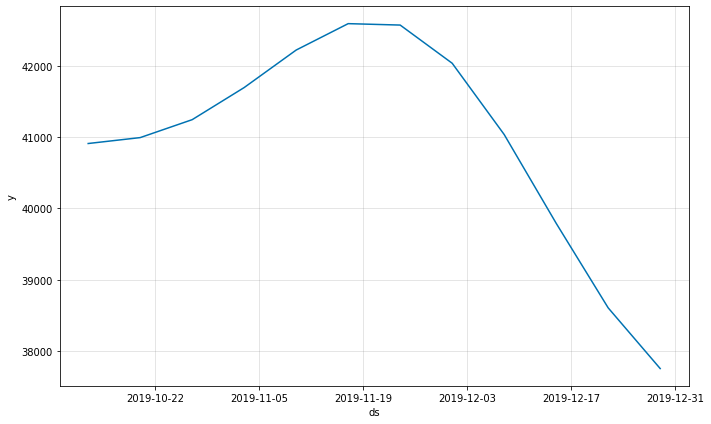

In [91]:
# Entrenamos el modelo y hacemos predicciones
future = model_np.make_future_dataframe(train_pr, periods=nobs)
forecast = model_np.predict(future)
forecasts_plot = model_np.plot(forecast)

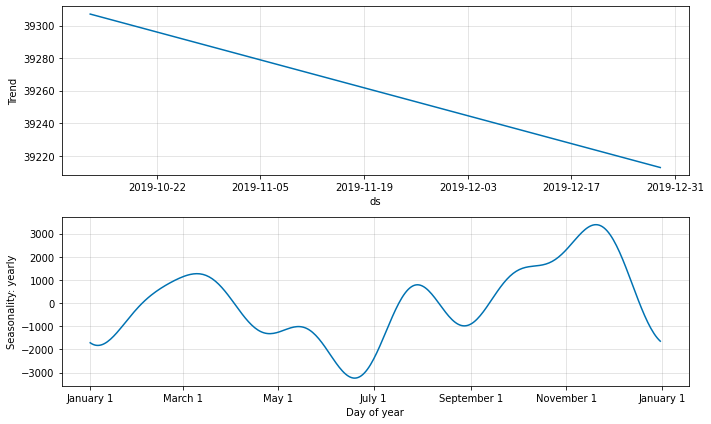

In [92]:
fig2 = model_np.plot_components(forecast)

In [93]:
metrics

,SmoothL1Loss,MAE,MSE,RegLoss
0,0.971131,41339.417969,2.522273e+09,0.0
1,0.771660,35030.091053,1.857626e+09,0.0
2,0.349917,21319.113896,7.039430e+08,0.0
3,0.174470,14725.701018,3.115664e+08,0.0
4,0.059185,8054.049411,1.054382e+08,0.0
5,0.021400,5174.273713,3.812481e+07,0.0
6,0.011558,3522.171855,2.059108e+07,0.0
7,0.010405,3442.948488,1.853701e+07,0.0
8,0.009664,3230.630015,1.721573e+07,0.0
9,0.009208,3081.975315,1.640352e+07,0.0


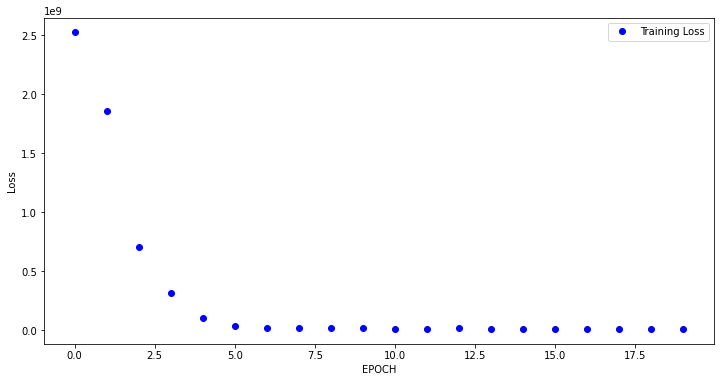

In [94]:
# Gráfico de errores MSE según EPOCH
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(metrics["MSE"], 'ob', linewidth=6, label="Training Loss")  
plt.ylabel('Loss')
plt.xlabel('EPOCH')
plt.legend()
plt.show()

Los errores disminuyen y luego aumentan a medida que aumentan las EPOCH. Los valores se estabilizan a partir del EPOCH 13. 

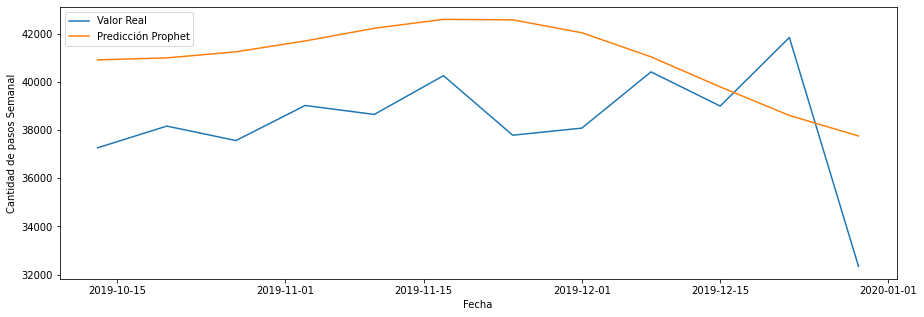

In [95]:
# Gráfico pronóstico Prophet vs Real
plt.figure(figsize = (15,5))
plt.plot(test_pr.ds, test_pr.y, label = 'Valor Real')
plt.plot(test_pr.ds, forecast.yhat1[-nobs:], label = 'Predicción Prophet')
#plt.fill_between(test_pr.ds, forecast.yhat1[-nobs:], forecast.yhat_lower[-nobs:], alpha=0.2, color ='g', label='Intervalo de confianza')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Semanal')
plt.legend()
plt.show()

In [96]:
# Error RMSE nobs = 12
y_pred = forecast.iloc[-nobs:]['yhat1']
y_true = test_pr['y']
rmse_npr = rmse(y_pred, y_true)
print("Error de test Prophet (RMSE):", rmse_npr)

Error de test Prophet (RMSE): 3410.7780143627447


### Neural Prophet con hiperparametros

Intentamos mejorar el modelo personalizando los hiperparametros

In [97]:
#model = NeuralProphet()
model = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.4,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=12,
    n_lags=0,
    num_hidden_layers=1,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
)
metrics = model.fit(train_pr, validate_each_epoch=True, 
                    valid_p=0.2, freq='W', 
                    plot_live_loss=True, epochs=20)

# Para obtener los resultados reales, la barra de progreso debe llegar al 100% de sus 211 procesos. 

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
2021-11-20 21:09:08,315 NP.forecaster WARNING Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
2021-11-20 21:09:08,339 NP.forecaster WARNING To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  Fil

  0%|          | 0/211 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.91E-01, min: 2.35E+00
2021-11-20 21:09:09,080 NP.utils_torch INFO  lr-range-test results: steep: 5.91E-01, min: 2.35E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 1.48E+00
2021-11-20 21:09:09,088 NP.utils_torch INFO  learning rate range test selected lr: 1.48E+00
Epoch[20/20]: 100%|██████████| 20/20 [00:00<00:00, 36.71it/s, SmoothL1Loss=0.00959, MAE=3.3e+3, MSE=1.79e+7, RegLoss=0, MAE_val=2.89e+3, MSE_val=1.08e+7, SmoothL1Loss_val=0.00581]


In [98]:
# Creamos un almacen de predicciones
future = model.make_future_dataframe(train_pr, periods=nobs, n_historic_predictions=len(train_pr))
# Incluimos los pronósticos en el almacen
forecast = model.predict(future)

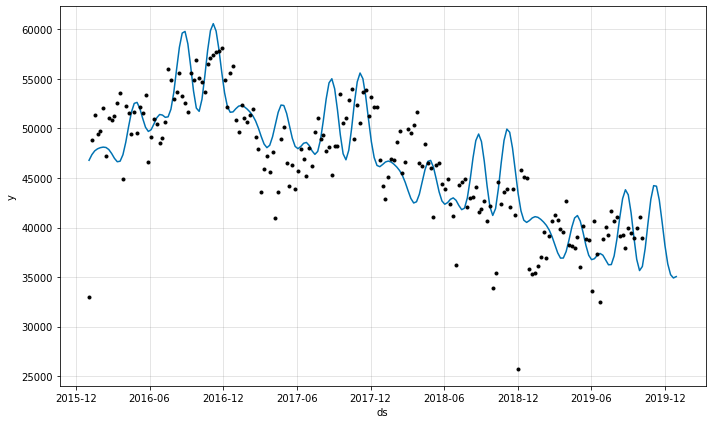

In [99]:
fig1 = model.plot(forecast)

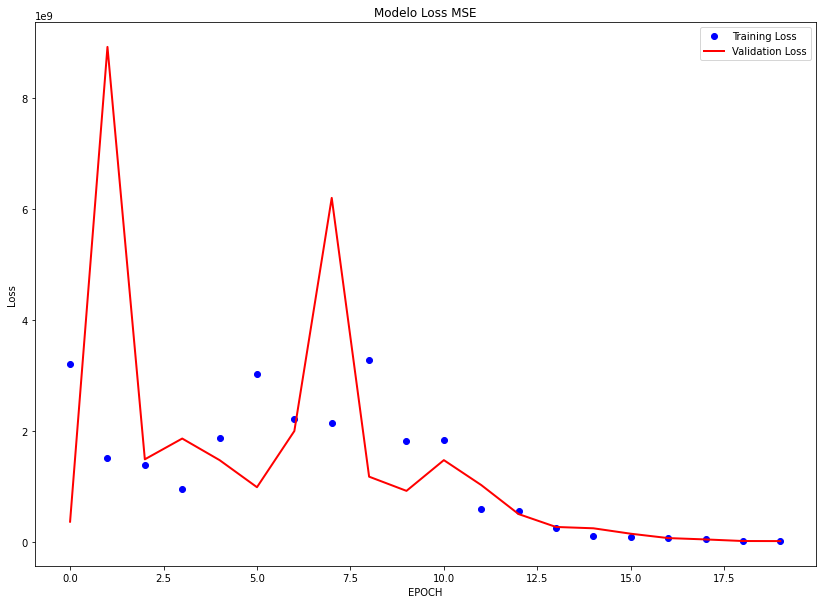

In [100]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MSE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["MSE_val"], '-r', linewidth=2, label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('EPOCH')
plt.title('Modelo Loss MSE')
plt.legend()
plt.show()

A medida que crecen las epocas el error disminuye. El modelo esta aprendiendo.

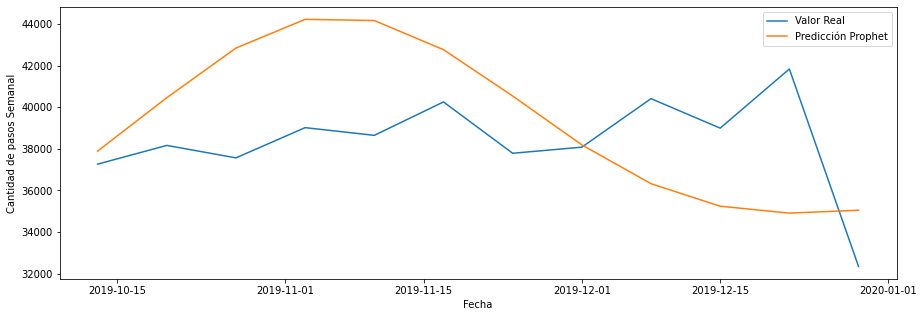

In [101]:
# Gráfico pronóstico Prophet vs Real
plt.figure(figsize = (15,5))
plt.plot(test_pr.ds, test_pr.y, label = 'Valor Real')
plt.plot(test_pr.ds, forecast.yhat1[-nobs:], label = 'Predicción Prophet')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Semanal')
plt.legend()
plt.show()

In [102]:
# nobs = 12
y_pred = forecast.iloc[-nobs:]['yhat1']
y_true = test_pr['y']
rmse_nprh = rmse(y_pred, y_true)
print("Error de test Prophet (RMSE):", rmse_nprh)

Error de test Prophet (RMSE): 3993.309821721585


**Redes Neuronales**

Las redes neuronales son modelos creados al ordenar operaciones matemáticas siguiendo una determinada estructura. La forma más común de representar la estructura de una red neuronal es mediante el uso de capas (layers), formadas a su vez por neuronas (unidades, units o neurons). Cada neurona, realiza una operación sencilla y está conectada a las neuronas de la capa anterior y de la capa siguiente mediante pesos, cuya función es regular la información que se propaga de una neurona a otra.

Este tipo de modelo funciona muy bien con series de tiempo, por lo que lo utilizaremos para nuestro proyecto. Particularmente probaremos las **Redes NeuronalesRedes Neuronales MLP (Multi_layered Perceptron)** y las **Redes Neuronales Recurrentes LSTM (Long-Short Term Memory)**.

Es importante mencionar que los algoritmos de Redes Neuronales son estocásticos. Esto significa que hacen uso de la aleatoriedad, como la inicialización a pesos aleatorios, y a su vez, la misma red entrenada con los mismos datos puede producir resultados diferentes.

### Redes Neuronales MLP (Multi_layered Perceptron)

Utilizaremos una estructura sencilla de red neuronal Feed Forward. 

Para aplicar los modelos de redes Neurorales convertiremos la serie de tiempo que contiene una columna con la "Cantidad de Pasos" y la convertiremos en varias columnas. De esta forma convertimos en un problema tipo supervisado, para poder alimentar nuestra red neuronal y poder entrenarla con backpropagation. Para hacerlo, debemos tener unas entradas y unas salidas para entrenar al modelo. Para ello comenzaremos definiendo la función **series_to_supervised()**. Lo que haremos es tomar los 52 días previos para “obtener” el 53. Utilizamos el MinMaxScaler para transformar el rango de nuestros valores entre -1 y 1 (ya que le favorece para hacer los cálculos a la Red Neuronal).

In [103]:
PASOS=52

# Convertimos la serie en un problema de aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = train_ef.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
print(reframed.shape)
print(reframed.head())

(145, 53)
    var1(t-52)  var1(t-51)  var1(t-50)  ...  var1(t-2)  var1(t-1)   var1(t)
52   -0.553345    0.429286    0.583346  ...   0.844607   0.888031  0.550843
53    0.429286    0.583346    0.464746  ...   0.888031   0.550843  0.473531
54    0.583346    0.464746    0.482440  ...   0.550843   0.473531  0.643070
55    0.464746    0.482440    0.624156  ...   0.473531   0.643070  0.561854
56    0.482440    0.624156    0.329033  ...   0.643070   0.561854  0.538597

[5 rows x 53 columns]


In [104]:
# split into train and test sets
values = reframed.values
n_test_days = len(test_ef) # Último trimestre de 2019
n_train_days = len(values) - (n_test_days + PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(81, 1, 52) (81,) (64, 1, 52) (64,)


In [105]:
# Creación del modelo y configuración de capas
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [106]:
# Entrenamiento 
EPOCHS= 40
model = crear_modeloFF()
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 52)             2756      
                                                                 
 flatten (Flatten)           (None, 52)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 53        
                                                                 
Total params: 2,809
Trainable params: 2,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
2/2 [==============================] - 1s 203ms/step - loss: 0.2429 - mse: 0.0995 - val_loss: 0.2628 - val_mse: 0.1125
Epoch 2/40
2/2 [==============================] - 0s 30ms/step - loss: 0.2155 - mse: 0.0699 - val_loss: 0.2602 - val_mse: 0.1118
Epoch 3/40
2/2 [==============================] - 0s 27ms/s

A medida que crecen las epocas el error disminuye. El modelo esta aprendiendo. 

64


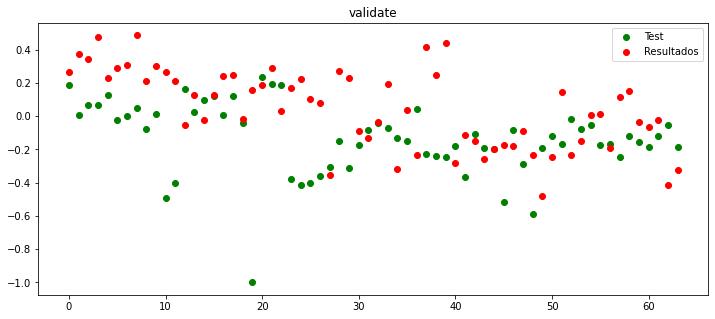

In [107]:
# Visualizamos los resultados
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g', label='Test')
plt.scatter(range(len(results)),results,c='r', label='Resultados')
plt.title('validate')
plt.legend()
plt.show()

Mientras más próximos estén los puentos rojos de los verdes, mejor fue la predicción.

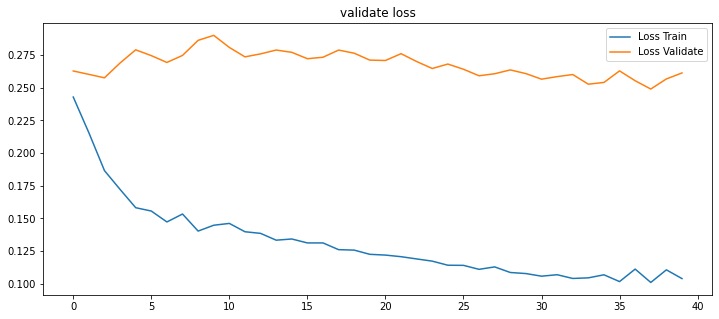

In [108]:
# Graficamos las perdidas (loss) o diferencias
plt.plot(history.history['loss'], label='Loss Train')
plt.title('loss')
plt.plot(history.history['val_loss'], label='Loss Validate')
plt.title('validate loss')
plt.legend()
plt.show()

Los gráficos tienen un comportamiento semejante, lo que significa que el modelo esta aprendiendo. Ademas se encuentras separados, lo que muestra que no hay overfitting. 

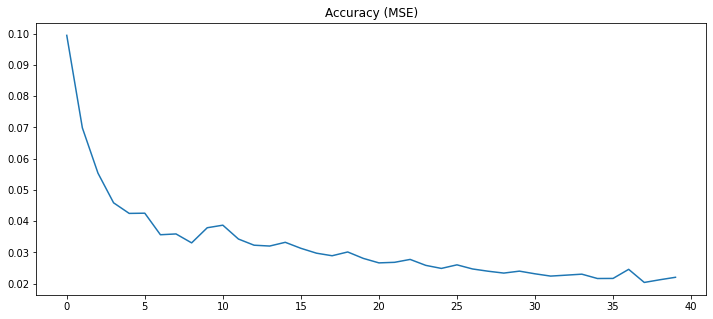

In [109]:
plt.title('Accuracy (MSE)')
plt.plot(history.history['mse'])
plt.show()

El error va disminuyendo a medida que avanzan las epoch. 

In [110]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2

,real,prediccion,diferencia
0,44931.000000,46265.382812,-1334.382812
1,42038.570312,47950.695312,-5912.125000
2,42993.570312,47478.070312,-4484.500000
3,43058.144531,49614.304688,-6556.160156
4,44043.855469,45667.152344,-1623.296875
...,...,...,...
59,39467.285156,41338.253906,-1870.968750
60,38941.714844,40897.812500,-1956.097656
61,39989.570312,41542.863281,-1553.292969
62,41081.144531,35268.195312,5812.949219


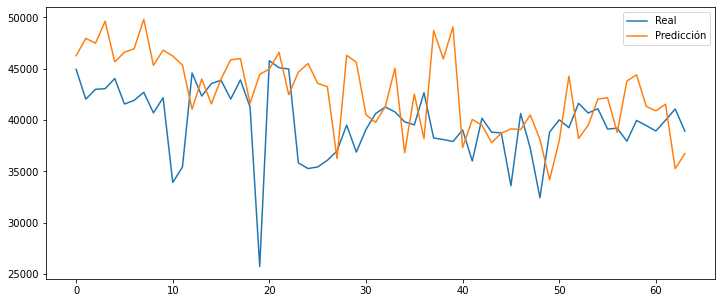

In [111]:
compara2['real'].plot(label='Real')
compara2['prediccion'].plot(label='Predicción')
plt.legend()
plt.show()

**Predicción**

Ahora predecimos el último trimestre de 2019 (12 semanas) a partir de la 52 semanas anteriores (1 año).


In [112]:
train_2019 = dataset_ill_ef_s['2018-7-09':'2019-09-30']
print(train_2019.shape)
print(train_2019.head(3))

(64, 1)
            cantidad_pasos
fecha                     
2018-07-15    44619.285714
2018-07-22    44931.000000
2018-07-29    42038.571429


In [113]:
values = train_2019.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[52]], axis=1, inplace=True)
print(reframed.shape)
reframed

(12, 52)


,var1(t-52),var1(t-51),var1(t-50),var1(t-49),var1(t-48),var1(t-47),var1(t-46),var1(t-45),var1(t-44),var1(t-43),var1(t-42),var1(t-41),var1(t-40),var1(t-39),var1(t-38),var1(t-37),var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
52,0.883756,0.914893,0.625966,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614
53,0.914893,0.625966,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869
54,0.625966,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453
55,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142
56,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142,0.533253
57,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142,0.533253,0.334813
58,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142,0.533253,0.334813,0.344031
59,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.80

In [114]:
values = reframed.values
x_test = values[11:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 52)


array([[[-0.18404889, -0.03451228,  0.8802452 ,  0.65609026,
          0.7776146 ,  0.80953693,  0.62653685,  0.8126478 ,
          0.5498204 , -1.        ,  1.        ,  0.93098974,
          0.9193883 ,  0.00651431, -0.04866838, -0.03321362,
          0.03157282,  0.12293005,  0.37335634,  0.11129975,
          0.33191562,  0.48567677,  0.5496068 ,  0.50148773,
          0.40569258,  0.37543964,  0.68829775,  0.24819326,
          0.233181  ,  0.21431565,  0.32646465,  0.02425194,
          0.44063997,  0.30525923,  0.29721117, -0.21552849,
          0.48557663,  0.15034318, -0.3322296 ,  0.3062439 ,
          0.42461443,  0.3488686 ,  0.58545303,  0.4911418 ,
          0.5332532 ,  0.33481264,  0.34403133,  0.2167561 ,
          0.4191203 ,  0.36911798,  0.31661844,  0.42128944]]],
      dtype=float32)

In [115]:
# Esta función ira guardando los valores predichos
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

**Pronóstico para el último trimestre 2019**

In [116]:
# Predicción y guardado de valores
results=[]
for i in range(12):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.18404889 -0.03451228  0.8802452   0.65609026  0.7776146
    0.80953693  0.62653685  0.8126478   0.5498204  -1.
    1.          0.93098974  0.9193883   0.00651431 -0.04866838
   -0.03321362  0.03157282  0.12293005  0.37335634  0.11129975
    0.33191562  0.48567677  0.5496068   0.50148773  0.40569258
    0.37543964  0.68829775  0.24819326  0.233181    0.21431565
    0.32646465  0.02425194  0.44063997  0.30525923  0.29721117
   -0.21552849  0.48557663  0.15034318 -0.3322296   0.3062439
    0.42461443  0.3488686   0.58545303  0.4911418   0.5332532
    0.33481264  0.34403133  0.2167561   0.4191203   0.36911798
    0.31661844  0.42128944]]]
[[[-0.03451228  0.8802452   0.65609026  0.7776146   0.80953693
    0.62653685  0.8126478   0.5498204  -1.          1.
    0.93098974  0.9193883   0.00651431 -0.04866838 -0.03321362
    0.03157282  0.12293005  0.37335634  0.11129975  0.33191562
    0.48567677  0.5496068   0.50148773  0.40569258  0.37543964
    0.68829775  0.24819326  0.233181    0.21

In [117]:
# Reconvertimos los datos
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.10328832], dtype=float32), array([0.08964369], dtype=float32), array([0.437247], dtype=float32), array([0.04798868], dtype=float32), array([0.22588451], dtype=float32), array([0.7478117], dtype=float32), array([0.36699182], dtype=float32), array([0.41324776], dtype=float32), array([-0.13200542], dtype=float32), array([0.15851875], dtype=float32), array([0.44307384], dtype=float32), array([0.5864867], dtype=float32)]


array([[36806.08264018],
       [36669.48730994],
       [40149.31941349],
       [36252.48194628],
       [38033.38446609],
       [43258.36025415],
       [39445.99969102],
       [39909.06468527],
       [34450.57372223],
       [37358.99056785],
       [40207.65140374],
       [41643.34734976]])

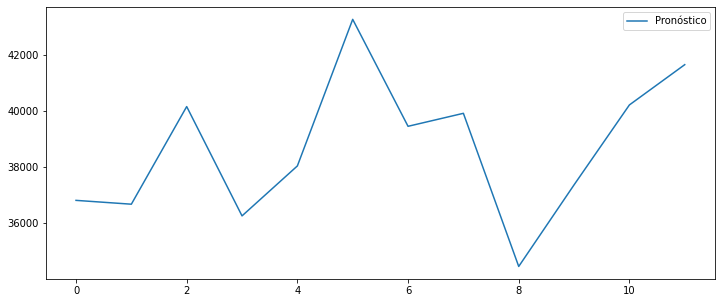

In [118]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['Pronóstico']
prediccion1SemanaDiciembre.plot()

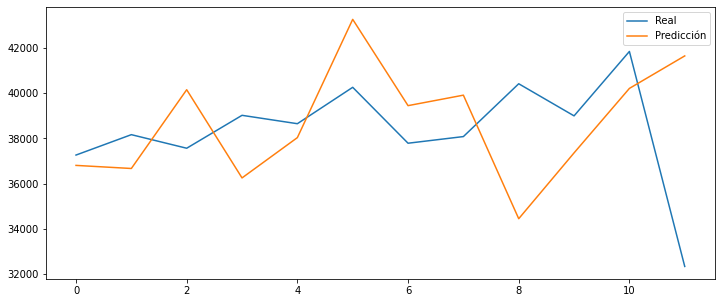

In [119]:
plt.plot(test_ef.values, label='Real')
plt.plot(prediccion1SemanaDiciembre.values, label='Predicción')
plt.legend()
plt.show()

In [120]:
# Error RMSE
y_pred = inverted
y_true = test_ef.values
rmse_mlp = float(rmse(y_pred, y_true ))
print("Error Redes Neuronales MLP (RMSE):", rmse_mlp)

Error Redes Neuronales MLP (RMSE): 3647.9258549312667


### Redes Neuronales Recurrentes LSTM


In [121]:
PASOS = 52

# load dataset
values = train_ef.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

,var1(t-52),var1(t-51),var1(t-50),var1(t-49),var1(t-48),var1(t-47),var1(t-46),var1(t-45),var1(t-44),var1(t-43),var1(t-42),var1(t-41),var1(t-40),var1(t-39),var1(t-38),var1(t-37),var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
52,0.223328,0.714643,0.791673,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422
53,0.714643,0.791673,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766
54,0.791673,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766,0.821535
55,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766,0.821535,0.780927
56,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766,0.821535,0.780927,0.769298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,0.523617,0.461726,0.507185,0.252436,0.298699,0.581703,0.512355,0.549952,0.559828,0.503212,0.560790,0.479478,0.000000,0.618752,0.597402,0.593813,0.311392,0.294319,0.299101,0.319144,0.347408,0.424884,0.343810,0.412063,0.459633,0.479411,0.464525,0.434888,0.425528,0.522319,0.386161,0.381517,0.375680,0.410377,0.316879,0.445700,0.403816,0.401326,0.242697,0.459602,0.355889,0.206592,0.404121,0.440742,0.417308,0.490502,0.461324,0.474352,0.412959,0.415811,0.376435,0.439042,0.423573
193,0.461726,0.507185,0.252436,0.298699,0.581703,0.512355,0.549952,0.559828,0.503212,0.560790,0.479478,0.000000,0.618752,0.597402,0.593813,0.311392,0.294319,0.299101,0.319144,0.347408,0.424884,0.343810,0.412063,0.459633,0.479411,0.464525,0.434888,0.425528,0.522319,0.386161,0.381517,0.375680,0.410377,0.316879,0.445700,0.403816,0.4

In [122]:
# Train/Test Split
values = reframed.values

# Obtengo la cantidad de semandas a restar
n_train_weeks = test_ef.shape[0] 

# Tomo la serie del 2016-01-03 al 2019-10-01 y le saco las semanas del test
train = values[:n_train_weeks, :]

# Tomo la serie del 2016-01-03 al 2019-10-01 y me quedo sólo con las ultimas 13 semanas 
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12, 1, 52) (12,) (133, 1, 52) (133,)


Diseño de la red: una capa LSTM con 50 unidades, activación ReLu.

Número de epocas de entrenamiento (epoch): 50

Función de perdida (loss), define el objetivo de minimizar el error cuadrático medio entre los valores predichos y los valores de prueba durante el entrenamiento.

Función de optimización se utilizará Adam

In [221]:
# Diseño de la Red
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [124]:
EPOCHS = 50

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 0.5215 - val_loss: 0.2677 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.4338 - val_loss: 0.2205 - 42ms/epoch - 42ms/step
Epoch 3/50
1/1 - 0s - loss: 0.3522 - val_loss: 0.1773 - 26ms/epoch - 26ms/step
Epoch 4/50
1/1 - 0s - loss: 0.2781 - val_loss: 0.1385 - 25ms/epoch - 25ms/step
Epoch 5/50
1/1 - 0s - loss: 0.2116 - val_loss: 0.1046 - 28ms/epoch - 28ms/step
Epoch 6/50
1/1 - 0s - loss: 0.1536 - val_loss: 0.0759 - 30ms/epoch - 30ms/step
Epoch 7/50
1/1 - 0s - loss: 0.1047 - val_loss: 0.0525 - 25ms/epoch - 25ms/step
Epoch 8/50
1/1 - 0s - loss: 0.0654 - val_loss: 0.0349 - 29ms/epoch - 29ms/step
Epoch 9/50
1/1 - 0s - loss: 0.0361 - val_loss: 0.0230 - 27ms/epoch - 27ms/step
Epoch 10/50
1/1 - 0s - loss: 0.0172 - val_loss: 0.0167 - 27ms/epoch - 27ms/step
Epoch 11/50
1/1 - 0s - loss: 0.0085 - val_loss: 0.0154 - 33ms/epoch - 33ms/step
Epoch 12/50
1/1 - 0s - loss: 0.0089 - val_loss: 0.0181 - 29ms/epoch - 29ms/step
Epoch 13/50
1/1 - 0s - loss: 0.0164 - val_loss: 0.023

64


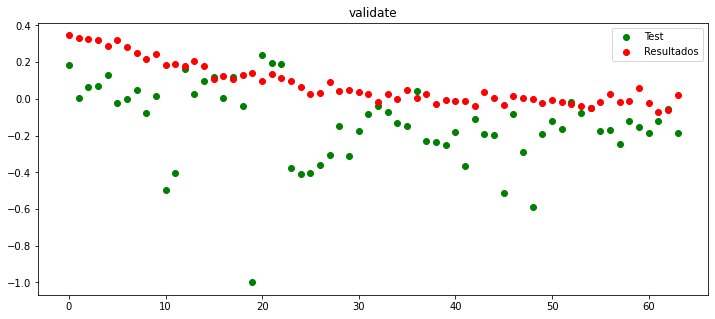

In [125]:
# Visualizamos los resultados
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g', label='Test')
plt.scatter(range(len(results)),results,c='r', label='Resultados')
plt.title('validate')
plt.legend()
plt.show()

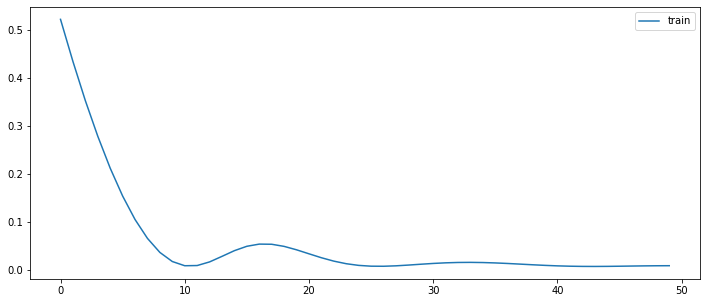

In [126]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [127]:
test_X.shape

(133, 1, 52)

In [128]:
# Predicción
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [129]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

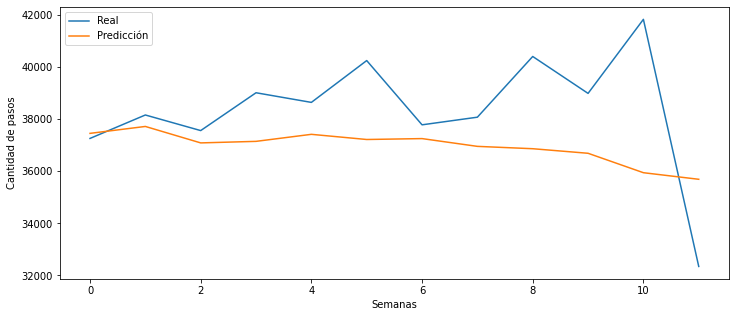

In [130]:
plt.plot(test_ef.values, label='Real')
plt.plot(inv_yhat[-len(test_ef):], label='Predicción')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Semanas')
plt.legend()
plt.show()

In [131]:
# Error RMSE
y_pred = inv_y
y_true = inv_yhat
rmse_LSTM = float(rmse(y_pred, y_true ))
print("Error Redes Neuronales LSTM (RMSE):", rmse_LSTM)

Error Redes Neuronales LSTM (RMSE): 3969.146728515625


# 2- Predicción 1er trimestre 2020

## Illia Efectivo | Semanal




### Train Test split

In [132]:
# Train y test para objetivo 2
train_ef2 = dataset_ill_ef_s['2016-01-01':'2019-12-31']
print(bold('Train2 Illia Efectivo: '), train_ef2, '\n')
test_ef2 = dataset_ill_ef_s['2020-01-01':'2020-03-20']
print(bold('Test2 Illia Efectivo: '), test_ef2)

Train2 Illia Efectivo: 
None             cantidad_pasos
fecha                     
2016-01-03    32987.666667
2016-01-10    48885.857143
2016-01-17    51378.428571
2016-01-24    49459.571429
2016-01-31    49745.857143
...                    ...
2019-12-01    38079.285714
2019-12-08    40413.000000
2019-12-15    38994.285714
2019-12-22    41840.142857
2019-12-29    32341.428571

[209 rows x 1 columns] 

Test2 Illia Efectivo: 
None             cantidad_pasos
fecha                     
2020-01-05    29513.285714
2020-01-12    34765.571429
2020-01-19    35259.714286
2020-01-26    34456.000000
2020-02-02    36190.714286
2020-02-09    35306.428571
2020-02-16    37351.142857
2020-02-23    36728.000000
2020-03-01    33641.000000
2020-03-08    36415.714286
2020-03-15    31827.571429


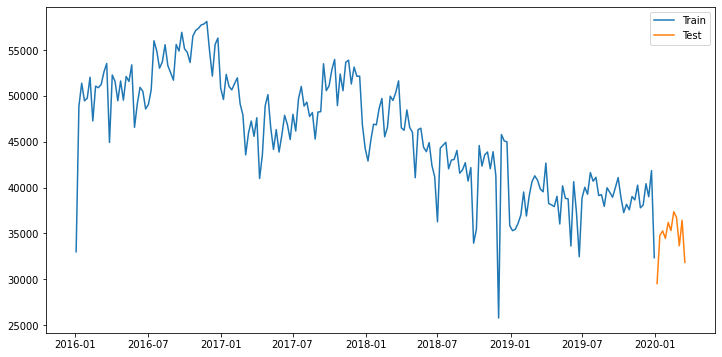

In [133]:
# Gráfico Train Test Semanal Illia|Efectivo
# ==============================================================================
plt.figure(figsize=(12,6))
plt.plot(train_ef2, label='Train')
plt.plot(test_ef2, label='Test')
plt.legend()
plt.show()

### Benchmark

In [134]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=16)

forecaster_rf.fit(y=train_ef2.cantidad_pasos)
forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=42)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

In [135]:
# Predicciones
# ==============================================================================
steps = 11
pred_bench_ef2 = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
pred_bench_ef2 = pd.Series(data=pred_bench_ef2, index=test_ef2.index)
predicciones_ef2 = test_ef2.copy()
predicciones_ef2['Benchmark'] = pred_bench_ef2
predicciones_ef2

,cantidad_pasos,Benchmark
fecha,,
2020-01-05,29513.285714,39035.514286
2020-01-12,34765.571429,38861.962857
2020-01-19,35259.714286,37959.744286
2020-01-26,34456.000000,39028.754286
2020-02-02,36190.714286,39438.048571
2020-02-09,35306.428571,39315.718571
2020-02-16,37351.142857,39231.170000
2020-02-23,36728.000000,38101.294286
2020-03-01,33641.000000,39596.937143


In [136]:
# Error Random Forest Regressor
# ==============================================================================
rmse_bench2 = np.sqrt(mean_squared_error(y_true = test_ef2[:], y_pred = pred_bench_ef2))
print(f"Error de test Benchmark (rmse): {rmse_bench2}")

Error de test Benchmark (rmse): 4864.919718355337


### Prophet

In [137]:
# Adecuación del dataset para Prophet.
train_pr2 = train_ef2.reset_index()
test_pr2 = test_ef2.reset_index() 

In [138]:
# Cambiamos los nombres de las columnas
train_pr2.columns = ['ds', 'y']
test_pr2.columns = ['ds', 'y']
# Cantidad de semanas a predecir
nobs2 = len(test_pr2.y)

print(train_pr2.head(3))
print(test_pr2.head(3))
print('\nSemanas datatest: ', len(train_pr2.y)+len(test_pr2.y))
print('Semanas train: ', len(train_pr2.y))
print('Semanas a predecir: ', nobs2)

          ds             y
0 2016-01-03  32987.666667
1 2016-01-10  48885.857143
2 2016-01-17  51378.428571
          ds             y
0 2020-01-05  29513.285714
1 2020-01-12  34765.571429
2 2020-01-19  35259.714286

Semanas datatest:  220
Semanas train:  209
Semanas a predecir:  11


In [139]:
# Comprobamos que la columna ds sea del typo DateTime
print(train_pr2.info())
print(test_pr2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      209 non-null    datetime64[ns]
 1   y       209 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      11 non-null     datetime64[ns]
 1   y       11 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 304.0 bytes
None


In [140]:
# Creamos una instancia del modelo Prophet
prophet_ef2 = Prophet()
# Entrenamos el modelo con el train
prophet_ef2.fit(train_pr2)

2021-11-20 21:09:23,028 fbprophet  INFO  Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2021-11-20 21:09:23,030 fbprophet  INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [141]:
# Creamos un almacen de predicciones
futuro2 = prophet_ef.make_future_dataframe(periods=nobs2, freq='W')
futuro2

,ds
0,2016-01-03
1,2016-01-10
2,2016-01-17
3,2016-01-24
4,2016-01-31
...,...
203,2019-11-24
204,2019-12-01
205,2019-12-08
206,2019-12-15


In [142]:
# Incluimos los pronósticos en el almacen
pronostico_pr_ef2 = prophet_ef2.predict(futuro2)
pronostico_pr_ef2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-03,52199.420834,44953.278935,52486.052321,52199.420834,52199.420834,-3764.735191,-3764.735191,-3764.735191,-3764.735191,-3764.735191,-3764.735191,0.0,0.0,0.0,48434.685644
1,2016-01-10,52192.018393,43500.336174,51417.987783,52192.018393,52192.018393,-4746.320286,-4746.320286,-4746.320286,-4746.320286,-4746.320286,-4746.320286,0.0,0.0,0.0,47445.698107
2,2016-01-17,52184.615951,45227.768200,52656.995018,52184.615951,52184.615951,-3258.324828,-3258.324828,-3258.324828,-3258.324828,-3258.324828,-3258.324828,0.0,0.0,0.0,48926.291123
3,2016-01-24,52177.213510,47438.258912,54991.995542,52177.213510,52177.213510,-996.371483,-996.371483,-996.371483,-996.371483,-996.371483,-996.371483,0.0,0.0,0.0,51180.842026
4,2016-01-31,52169.811068,48277.220833,55785.656778,52169.811068,52169.811068,133.863875,133.863875,133.863875,133.863875,133.863875,133.863875,0.0,0.0,0.0,52303.674943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-11-24,36253.256507,34298.891424,41724.197044,36253.256507,36253.256507,1813.175374,1813.175374,1813.175374,1813.175374,1813.175374,1813.175374,0.0,0.0,0.0,38066.431881
204,2019-12-01,36149.220216,34436.186777,42088.136334,36149.220216,36149.220216,1967.152002,1967.152002,1967.152002,1967.152002,1967.152002,1967.152002,0.0,0.0,0.0,38116.372217
205,2019-12-08,36045.183924,35448.524526,43227.876449,36045.183924,36045.183924,3194.027906,3194.027906,3194.027906,3194.027906,3194.027906,3194.027906,0.0,0.0,0.0,39239.211830
206,2019-12-15,35941.147632,35906.180368,42790.837059,35941.147632,35941.147632,3623.946702,3623.946702,3623.946702,3623.946702,3623.946702,3623.946702,0.0,0.0,0.0,39565.094334


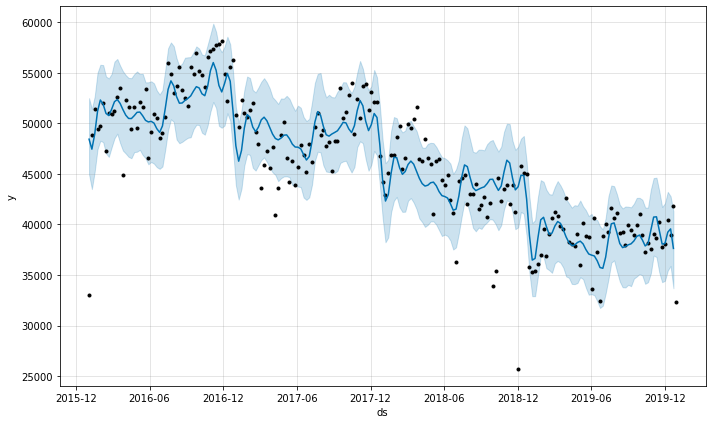

In [143]:
fig1 = prophet_ef2.plot(pronostico_pr_ef2)

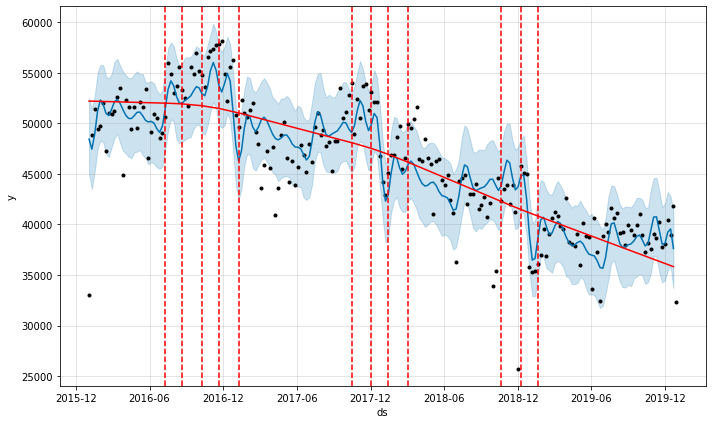

In [144]:
# Gráfico con puntos de cambio de tendencia
fig1 = prophet_ef2.plot(pronostico_pr_ef2)
a = add_changepoints_to_plot(fig1.gca(), prophet_ef2, pronostico_pr_ef2)

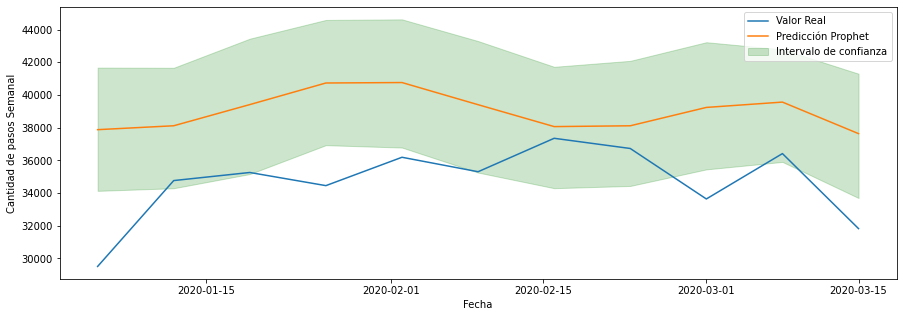

In [145]:
# Gráfico pronóstico Prophet vs Real
plt.figure(figsize = (15,5))
plt.plot(test_pr2.ds, test_pr2.y, label = 'Valor Real')
plt.plot(test_pr2.ds, pronostico_pr_ef2.yhat[-nobs2:], label = 'Predicción Prophet')
plt.fill_between(test_pr2.ds, pronostico_pr_ef2.yhat_upper[-nobs2:], pronostico_pr_ef2.yhat_lower[-nobs2:], alpha=0.2, color ='g', label='Intervalo de confianza')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Semanal')
plt.legend()
plt.show()

In [146]:
# nobs = 11
y_pred = pronostico_pr_ef2.iloc[-nobs2:]['yhat']
y_true = test_pr2['y']
rmse_prop_ef2 = rmse(y_pred, y_true)
print("Error de test Prophet (RMSE):", rmse_prop_ef2)

Error de test Prophet (RMSE): 4795.826609198308


### Neural Prophet

In [147]:
nobs2 = len(test_pr2.y)
# Creamos una instancia del modelo Neural Prophet
model_np2 = NeuralProphet()
# Entrenamos el modelo con el train
metrics = model_np2.fit(train_pr2, freq='W', epochs=20)

# Para obtener los resultados reales, la barra de progreso debe llegar al 100% de sus 217 procesos. 

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
2021-11-20 21:09:25,963 NP.utils   INFO  Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
2021-11-20 21:09:25,968 NP.utils   INFO  Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
2021-11-20 21:09:25,972 NP.config  INFO  Auto-set batch_size to 16


  0%|          | 0/217 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.96E-01, min: 6.81E-01
2021-11-20 21:09:26,715 NP.utils_torch INFO  lr-range-test results: steep: 1.96E-01, min: 6.81E-01
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 4.50E-01
2021-11-20 21:09:26,718 NP.utils_torch INFO  learning rate range test selected lr: 4.50E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:00<00:00, 30.85it/s, SmoothL1Loss=0.00463, MAE=2.03e+3, MSE=8.25e+6, RegLoss=0]


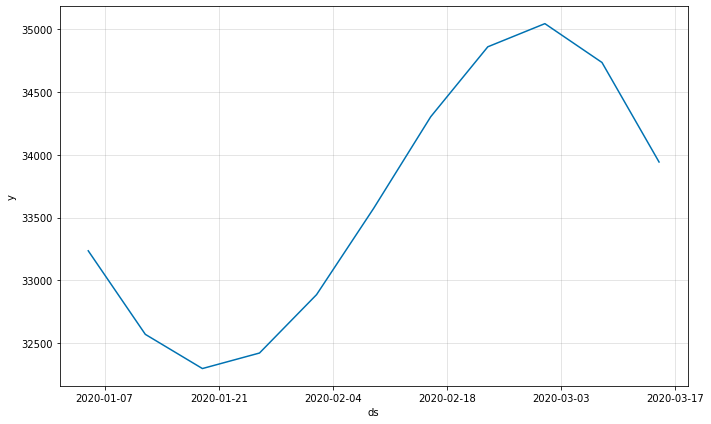

In [148]:
# Entrenamos el modelo y hacemos predicciones
future = model_np2.make_future_dataframe(train_pr2, periods=nobs2)
forecast = model_np2.predict(future)
forecasts_plot = model_np2.plot(forecast)

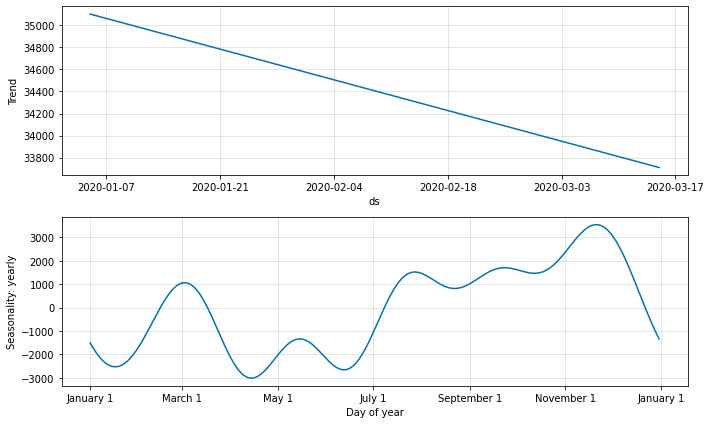

In [149]:
fig2 = model_np2.plot_components(forecast)

In [150]:
metrics

,SmoothL1Loss,MAE,MSE,RegLoss
0,0.588146,29263.925837,1.293820e+09,0.0
1,0.291926,19369.988094,5.501817e+08,0.0
2,0.129226,12566.592591,2.335355e+08,0.0
3,0.090992,9790.821490,1.627501e+08,0.0
4,0.054592,7839.994393,9.724847e+07,0.0
5,0.048754,7096.704265,8.684791e+07,0.0
6,0.065146,7892.301996,1.181475e+08,0.0
7,0.033143,6270.247477,5.904040e+07,0.0
8,0.099146,10660.978974,1.767448e+08,0.0
9,0.081027,9121.367057,1.458101e+08,0.0


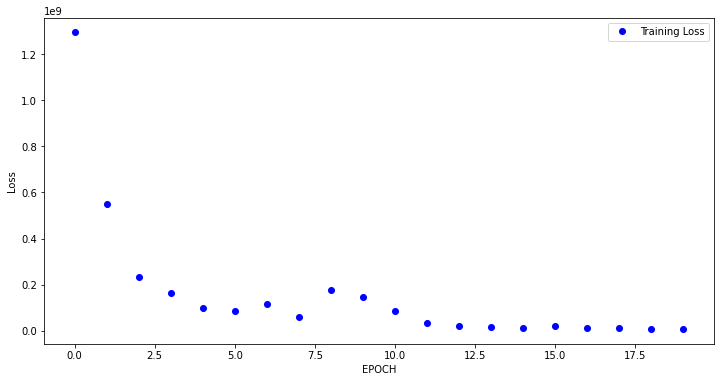

In [151]:
# Gráfico de errores MSE según EPOCH
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(metrics["MSE"], 'ob', linewidth=6, label="Training Loss")  
plt.ylabel('Loss')
plt.xlabel('EPOCH')
plt.legend()
plt.show()

Los errores disminuyen a medida que aumentan las EPOCH. Los valores se estabilizan a partir del EPOCH 6. 

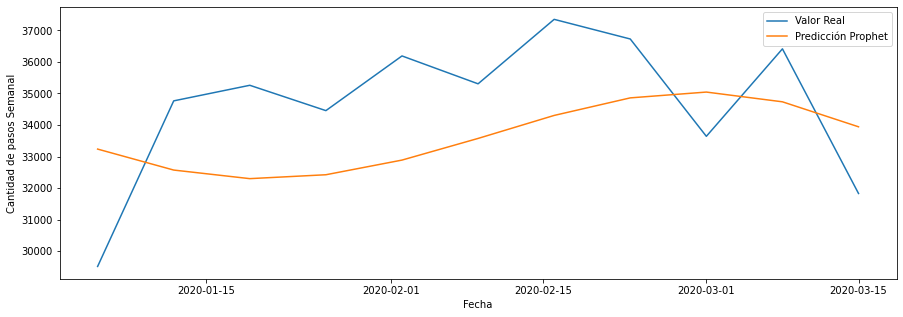

In [152]:
# Gráfico pronóstico Prophet vs Real
plt.figure(figsize = (15,5))
plt.plot(test_pr2.ds, test_pr2.y, label = 'Valor Real')
plt.plot(test_pr2.ds, forecast.yhat1[-nobs2:], label = 'Predicción Prophet')
#plt.fill_between(test_pr.ds, forecast.yhat1[-nobs:], forecast.yhat_lower[-nobs:], alpha=0.2, color ='g', label='Intervalo de confianza')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Semanal')
plt.legend()
plt.show()

In [153]:
# Error RMSE nobs = 11
y_pred = forecast.iloc[-nobs2:]['yhat1']
y_true = test_pr2['y']
rmse_npr2 = rmse(y_pred, y_true)
print("Error de test Prophet (RMSE):", rmse_npr2)

Error de test Prophet (RMSE): 2477.9609287275457


### Neural Prophet con hiperparametros

In [154]:
#model = NeuralProphet()
model = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.4,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=12,
    n_lags=0,
    num_hidden_layers=1,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
)
metrics = model.fit(train_pr2, validate_each_epoch=True, 
                    valid_p=0.2, freq='W', 
                    plot_live_loss=True, epochs=20)

# Para obtener los resultados reales, la barra de progreso debe llegar al 100% de sus 212 procesos. 

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
2021-11-20 21:09:28,609 NP.forecaster WARNING Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
WARNING - (NP.forecaster._train) - To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py", line 545, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
2021-11-20 21:09:28,625 NP.forecaster WARNING To plot live loss, please install neuralprophet[live].Using pip: 'pip install neuralprophet[live]'Or install the missing package manually: 'pip install livelossplot'
Traceback (most recent call last):
  Fil

  0%|          | 0/212 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.49E-02, min: 2.39E+00
2021-11-20 21:09:29,360 NP.utils_torch INFO  lr-range-test results: steep: 8.49E-02, min: 2.39E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 7.87E-01
2021-11-20 21:09:29,364 NP.utils_torch INFO  learning rate range test selected lr: 7.87E-01
Epoch[20/20]: 100%|██████████| 20/20 [00:00<00:00, 36.24it/s, SmoothL1Loss=0.00638, MAE=2.42e+3, MSE=1.17e+7, RegLoss=0, MAE_val=1.84e+3, MSE_val=5.88e+6, SmoothL1Loss_val=0.00321]


In [155]:
# Creamos un almacen de predicciones
future = model.make_future_dataframe(train_pr2, periods=nobs2, n_historic_predictions=len(train_pr2))
# Incluimos los pronósticos en el almacen
forecast = model.predict(future)

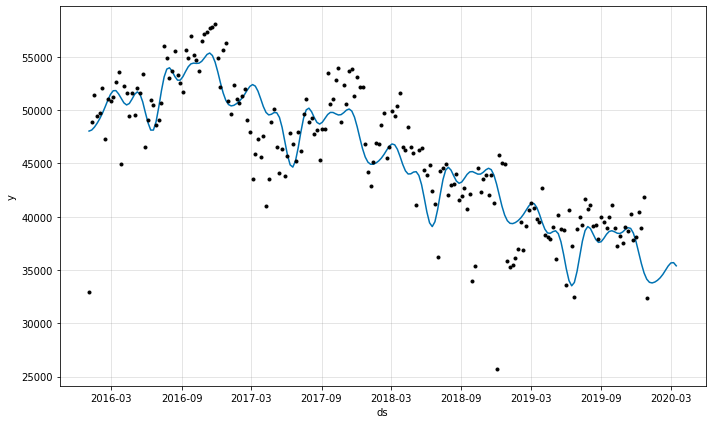

In [156]:
fig1 = model.plot(forecast)

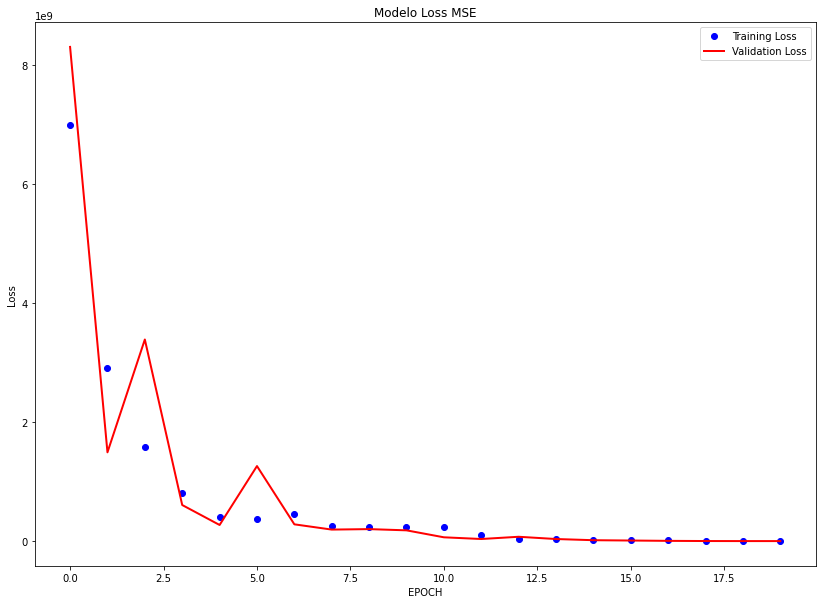

In [157]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MSE"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["MSE_val"], '-r', linewidth=2, label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('EPOCH')
plt.title('Modelo Loss MSE')
plt.legend()
plt.show()

A medida que crecen las epocas el error disminuye. El modelo esta aprendiendo.

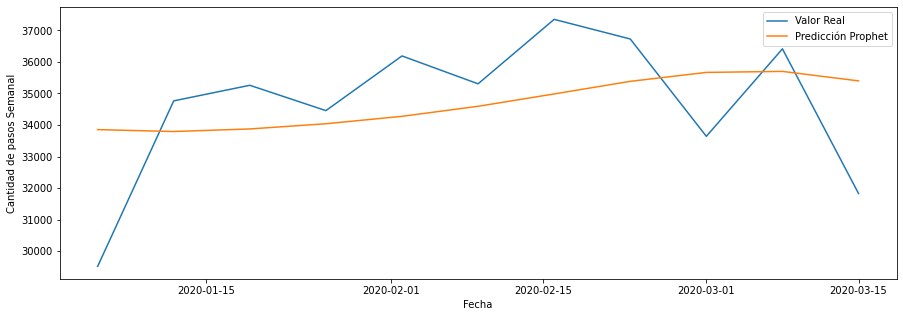

In [158]:
# Gráfico pronóstico Prophet vs Real
plt.figure(figsize = (15,5))
plt.plot(test_pr2.ds, test_pr2.y, label = 'Valor Real')
plt.plot(test_pr2.ds, forecast.yhat1[-nobs2:], label = 'Predicción Prophet')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Semanal')
plt.legend()
plt.show()

In [159]:
# Error RMSE nobs = 11
y_pred = forecast.iloc[-nobs2:]['yhat1']
y_true = test_pr2['y']
rmse_nprh2 = rmse(y_pred, y_true)
print("Error de test Prophet (RMSE):", rmse_nprh2)

Error de test Prophet (RMSE): 2149.86127711179


### Redes Neuronales

### Redes Neuronales MLP (Multi_layered Perceptron)

Utilizaremos una estructura sencilla de red neuronal Feed Forward. 

In [160]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

In [161]:
PASOS=52

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = train_ef2.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
print(reframed.shape)
print(reframed.head())

(157, 53)
    var1(t-52)  var1(t-51)  var1(t-50)  ...  var1(t-2)  var1(t-1)   var1(t)
52   -0.553345    0.429286    0.583346  ...   0.844607   0.888031  0.550843
53    0.429286    0.583346    0.464746  ...   0.888031   0.550843  0.473531
54    0.583346    0.464746    0.482440  ...   0.550843   0.473531  0.643070
55    0.464746    0.482440    0.624156  ...   0.473531   0.643070  0.561854
56    0.482440    0.624156    0.329033  ...   0.643070   0.561854  0.538597

[5 rows x 53 columns]


In [162]:
# split into train and test sets
values = reframed.values
n_test_days = len(test_ef2) # Último trimestre de 2019
n_train_days = len(values) - (n_test_days + PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(94, 1, 52) (94,) (63, 1, 52) (63,)


In [163]:
# Creación del modelo y configuración de capas
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [164]:
# Entrenamiento 
EPOCHS= 40
model = crear_modeloFF()
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1, 52)             2756      
                                                                 
 flatten_1 (Flatten)         (None, 52)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 53        
                                                                 
Total params: 2,809
Trainable params: 2,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
2/2 [==============================] - 1s 504ms/step - loss: 0.9977 - mse: 1.0872 - val_loss: 0.4110 - val_mse: 0.2222
Epoch 2/40
2/2 [==============================] - 0s 23ms/step - loss: 0.7647 - mse: 0.6747 - val_loss: 0.3549 - val_mse: 0.1779
Epoch 3/40
2/2 [==============================] - 0s 24ms

A medida que crecen las epocas el error disminuye. El modelo esta aprendiendo. 

63


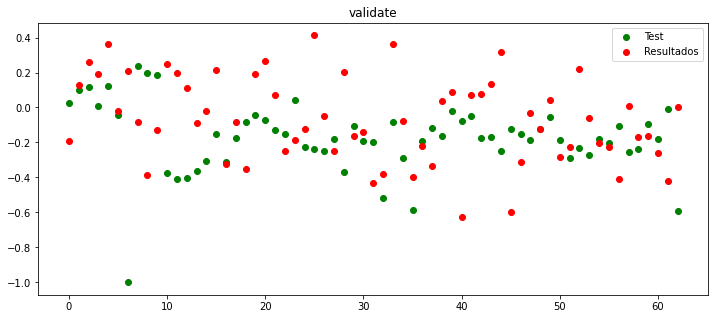

In [165]:
# Visualizamos los resultados
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g', label='Test')
plt.scatter(range(len(results)),results,c='r', label='Resultados')
plt.title('validate')
plt.legend()
plt.show()

Mientras más próximos estén los puentos rojos de los verdes, mejor fue la predicción.

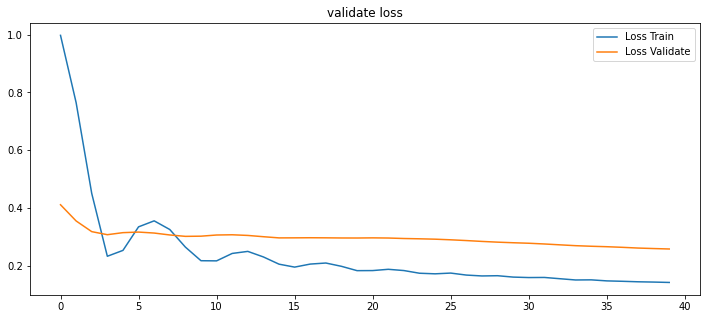

In [166]:
# Graficamos las perdidas (loss) o diferencias
plt.plot(history.history['loss'], label='Loss Train')
plt.title('loss')
plt.plot(history.history['val_loss'], label='Loss Validate')
plt.title('validate loss')
plt.legend()
plt.show()

Los gráficos tienen un comportamiento semejante, lo que significa que el modelo esta aprendiendo. Ademas se encuentras separados, lo que muestra que no hay overfitting. 

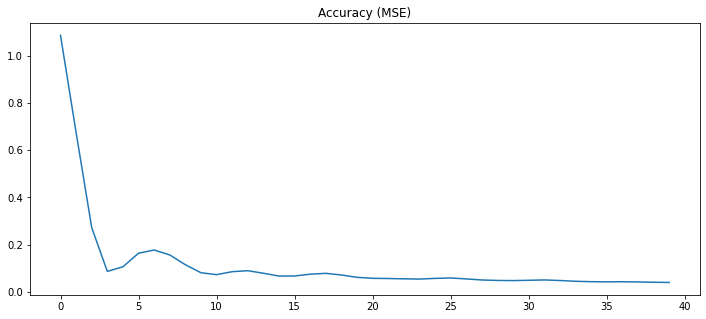

In [167]:
plt.title('Accuracy (MSE)')
plt.plot(history.history['mse'])
plt.show()

El error va disminuyendo a medida que avanzan las epoch. 

In [168]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2

,real,prediccion,diferencia
0,42340.144531,38832.492188,3507.652344
1,43556.714844,44024.074219,-467.359375
2,43876.285156,46160.878906,-2284.593750
3,42044.285156,45039.605469,-2995.320312
4,43907.429688,47850.179688,-3942.750000
...,...,...,...
58,38079.285156,39203.675781,-1124.390625
59,40413.000000,39337.539062,1075.460938
60,38994.285156,37706.632812,1287.652344
61,41840.144531,35140.039062,6700.105469


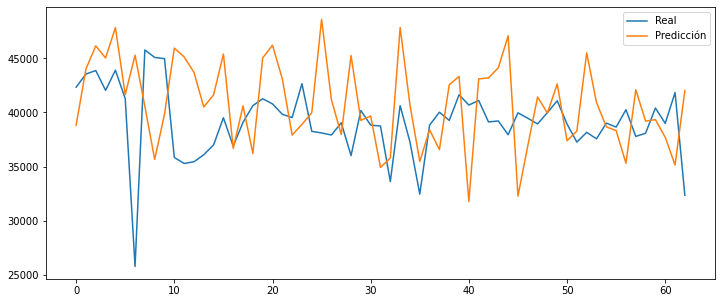

In [169]:
compara2['real'].plot(label='Real')
compara2['prediccion'].plot(label='Predicción')
plt.legend()
plt.show()

**Predicción**

Ahora predecimos el último trimestre de 2019 (12 semanas) a partir de la 52 semanas anteriores (1 año).


In [170]:
train_2019 = dataset_ill_ef_s['2018-7-09':'2019-09-30']
print(train_2019.shape)
print(train_2019.head(3))

(64, 1)
            cantidad_pasos
fecha                     
2018-07-15    44619.285714
2018-07-22    44931.000000
2018-07-29    42038.571429


In [171]:
values = train_2019.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[52]], axis=1, inplace=True)
print(reframed.shape)
reframed

(12, 52)


,var1(t-52),var1(t-51),var1(t-50),var1(t-49),var1(t-48),var1(t-47),var1(t-46),var1(t-45),var1(t-44),var1(t-43),var1(t-42),var1(t-41),var1(t-40),var1(t-39),var1(t-38),var1(t-37),var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
52,0.883756,0.914893,0.625966,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614
53,0.914893,0.625966,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869
54,0.625966,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453
55,0.721362,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142
56,0.727812,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142,0.533253
57,0.826275,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142,0.533253,0.334813
58,0.578446,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.809537,0.626537,0.812648,0.549820,-1.000000,1.000000,0.930990,0.919388,0.006514,-0.048668,-0.033214,0.031573,0.122930,0.373356,0.111300,0.331916,0.485677,0.549607,0.501488,0.405693,0.375440,0.688298,0.248193,0.233181,0.214316,0.326465,0.024252,0.440640,0.305259,0.297211,-0.215528,0.485577,0.150343,-0.332230,0.306244,0.424614,0.348869,0.585453,0.491142,0.533253,0.334813,0.344031
59,0.614065,0.692493,0.492440,0.639380,-0.184049,-0.034512,0.880245,0.656090,0.777615,0.80

In [172]:
values = reframed.values
x_test = values[11:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 52)


array([[[-0.18404889, -0.03451228,  0.8802452 ,  0.65609026,
          0.7776146 ,  0.80953693,  0.62653685,  0.8126478 ,
          0.5498204 , -1.        ,  1.        ,  0.93098974,
          0.9193883 ,  0.00651431, -0.04866838, -0.03321362,
          0.03157282,  0.12293005,  0.37335634,  0.11129975,
          0.33191562,  0.48567677,  0.5496068 ,  0.50148773,
          0.40569258,  0.37543964,  0.68829775,  0.24819326,
          0.233181  ,  0.21431565,  0.32646465,  0.02425194,
          0.44063997,  0.30525923,  0.29721117, -0.21552849,
          0.48557663,  0.15034318, -0.3322296 ,  0.3062439 ,
          0.42461443,  0.3488686 ,  0.58545303,  0.4911418 ,
          0.5332532 ,  0.33481264,  0.34403133,  0.2167561 ,
          0.4191203 ,  0.36911798,  0.31661844,  0.42128944]]],
      dtype=float32)

In [173]:
# Esta función ira guardando los valores predichos
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

**Pronóstico para el último trimestre 2019**

In [174]:
# Predicción y guardado de valores
results=[]
for i in range(12):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.18404889 -0.03451228  0.8802452   0.65609026  0.7776146
    0.80953693  0.62653685  0.8126478   0.5498204  -1.
    1.          0.93098974  0.9193883   0.00651431 -0.04866838
   -0.03321362  0.03157282  0.12293005  0.37335634  0.11129975
    0.33191562  0.48567677  0.5496068   0.50148773  0.40569258
    0.37543964  0.68829775  0.24819326  0.233181    0.21431565
    0.32646465  0.02425194  0.44063997  0.30525923  0.29721117
   -0.21552849  0.48557663  0.15034318 -0.3322296   0.3062439
    0.42461443  0.3488686   0.58545303  0.4911418   0.5332532
    0.33481264  0.34403133  0.2167561   0.4191203   0.36911798
    0.31661844  0.42128944]]]
[[[-0.03451228  0.8802452   0.65609026  0.7776146   0.80953693
    0.62653685  0.8126478   0.5498204  -1.          1.
    0.93098974  0.9193883   0.00651431 -0.04866838 -0.03321362
    0.03157282  0.12293005  0.37335634  0.11129975  0.33191562
    0.48567677  0.5496068   0.50148773  0.40569258  0.37543964
    0.68829775  0.24819326  0.233181    0.21

In [175]:
# Reconvertimos los datos
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.5258501], dtype=float32), array([0.09893131], dtype=float32), array([0.30131018], dtype=float32), array([0.7423745], dtype=float32), array([0.50669706], dtype=float32), array([0.44693682], dtype=float32), array([0.40260872], dtype=float32), array([-0.16831106], dtype=float32), array([0.5367116], dtype=float32), array([0.3304104], dtype=float32), array([0.4152751], dtype=float32), array([0.3626911], dtype=float32)]


array([[41036.31885081],
       [36762.46499561],
       [38788.46549106],
       [43203.92887787],
       [40844.57894115],
       [40246.32339262],
       [39802.55799423],
       [34087.12057514],
       [41145.05211994],
       [39079.78562289],
       [39929.36016988],
       [39402.94555299]])

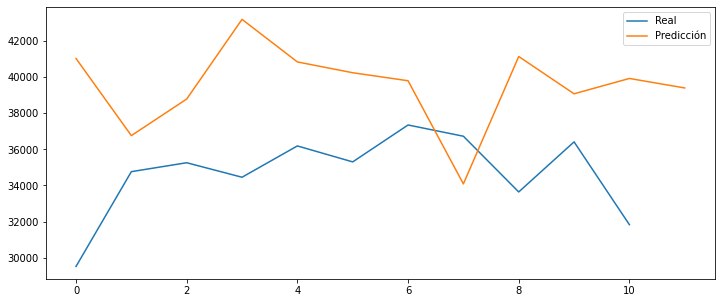

In [176]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['Pronóstico']
plt.plot(test_ef2.values, label='Real')
plt.plot(prediccion1SemanaDiciembre.values, label='Predicción')
plt.legend()
plt.show()

In [177]:
# Error RMSE
y_pred = inverted[-len(test_ef2):]
y_true = test_ef2.values
rmse_mlp2 = float(rmse(y_pred, y_true ))
print("Error Redes Neuronales MLP (RMSE):", rmse_mlp2)

Error Redes Neuronales MLP (RMSE): 5549.762392477764


### Redes Neuronales Recurrentes LSTM


In [178]:
PASOS = 52

# load dataset
values = train_ef2.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed

,var1(t-52),var1(t-51),var1(t-50),var1(t-49),var1(t-48),var1(t-47),var1(t-46),var1(t-45),var1(t-44),var1(t-43),var1(t-42),var1(t-41),var1(t-40),var1(t-39),var1(t-38),var1(t-37),var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
52,0.223328,0.714643,0.791673,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422
53,0.714643,0.791673,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766
54,0.791673,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766,0.821535
55,0.732373,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766,0.821535,0.780927
56,0.741220,0.812078,0.664517,0.781775,0.776786,0.787218,0.829539,0.858399,0.592065,0.819544,0.797951,0.732607,0.799306,0.734598,0.814648,0.797726,0.853692,0.642941,0.721689,0.777868,0.764217,0.705036,0.720051,0.768998,0.934842,0.900861,0.842496,0.863158,0.921460,0.850938,0.827084,0.802034,0.922343,0.900031,0.963335,0.907801,0.895580,0.861524,0.950744,0.969436,0.976866,0.988208,0.991590,1.000000,0.900936,0.815866,0.922303,0.944016,0.775422,0.736766,0.821535,0.780927,0.769298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.000000,0.618752,0.597402,0.593813,0.311392,0.294319,0.299101,0.319144,0.347408,0.424884,0.343810,0.412063,0.459633,0.479411,0.464525,0.434888,0.425528,0.522319,0.386161,0.381517,0.375680,0.410377,0.316879,0.445700,0.403816,0.401326,0.242697,0.459602,0.355889,0.206592,0.404121,0.440742,0.417308,0.490502,0.461324,0.474352,0.412959,0.415811,0.376435,0.439042,0.423573,0.407331,0.439713,0.473447,0.406849,0.355447,0.383292,0.364763,0.409701,0.398254,0.447938,0.371606,0.380678
205,0.618752,0.597402,0.593813,0.311392,0.294319,0.299101,0.319144,0.347408,0.424884,0.343810,0.412063,0.459633,0.479411,0.464525,0.434888,0.425528,0.522319,0.386161,0.381517,0.375680,0.410377,0.316879,0.445700,0.403816,0.401326,0.242697,0.459602,0.355889,0.206592,0.404121,0.440742,0.417308,0.490502,0.461324,0.474352,0.412959,0.4

In [179]:
# Train/Test Split
values = reframed.values

# Obtengo la cantidad de semandas a restar
n_train_weeks = test_ef2.shape[0] 

# Tomo la serie del 2016-01-03 al 2019-10-01 y le saco las semanas del test
train = values[:n_train_weeks, :]

# Tomo la serie del 2016-01-03 al 2019-10-01 y me quedo sólo con las ultimas 13 semanas 
test = values[n_train_weeks:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(11, 1, 52) (11,) (146, 1, 52) (146,)


In [180]:
# Diseño de la Red
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [181]:
EPOCHS = 50

# fit network
history = model.fit(
    train_X, 
    train_y, 
    epochs=EPOCHS, 
    batch_size=72, 
    validation_data=(test_X, test_y), 
    verbose=2, 
    shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 0.7670 - val_loss: 0.3961 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.6788 - val_loss: 0.3504 - 24ms/epoch - 24ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6003 - val_loss: 0.3095 - 24ms/epoch - 24ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5296 - val_loss: 0.2729 - 27ms/epoch - 27ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4653 - val_loss: 0.2399 - 24ms/epoch - 24ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4071 - val_loss: 0.2105 - 22ms/epoch - 22ms/step
Epoch 7/50
1/1 - 0s - loss: 0.3545 - val_loss: 0.1839 - 24ms/epoch - 24ms/step
Epoch 8/50
1/1 - 0s - loss: 0.3061 - val_loss: 0.1602 - 25ms/epoch - 25ms/step
Epoch 9/50
1/1 - 0s - loss: 0.2613 - val_loss: 0.1388 - 48ms/epoch - 48ms/step
Epoch 10/50
1/1 - 0s - loss: 0.2210 - val_loss: 0.1193 - 27ms/epoch - 27ms/step
Epoch 11/50
1/1 - 0s - loss: 0.1850 - val_loss: 0.1014 - 28ms/epoch - 28ms/step
Epoch 12/50
1/1 - 0s - loss: 0.1529 - val_loss: 0.0849 - 30ms/epoch - 30ms/step
Epoch 13/50
1/1 - 0s - loss: 0.1236 - val_loss: 0.070

63


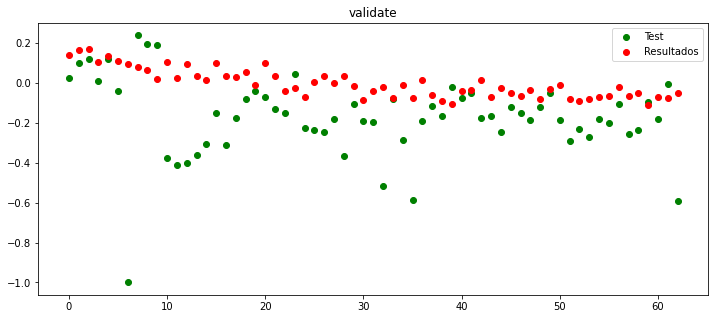

In [182]:
# Visualizamos los resultados
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g', label='Test')
plt.scatter(range(len(results)),results,c='r', label='Resultados')
plt.title('validate')
plt.legend()
plt.show()

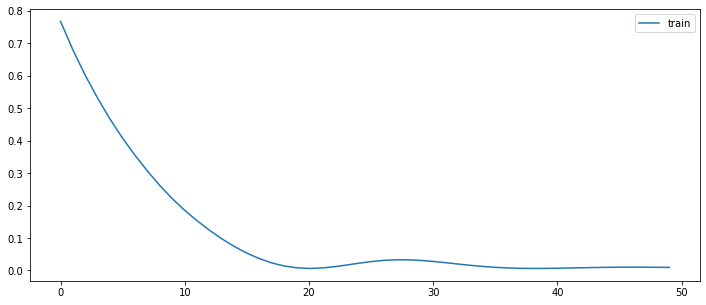

In [183]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [184]:
test_X.shape

(146, 1, 52)

In [185]:
# Predicción
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [186]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

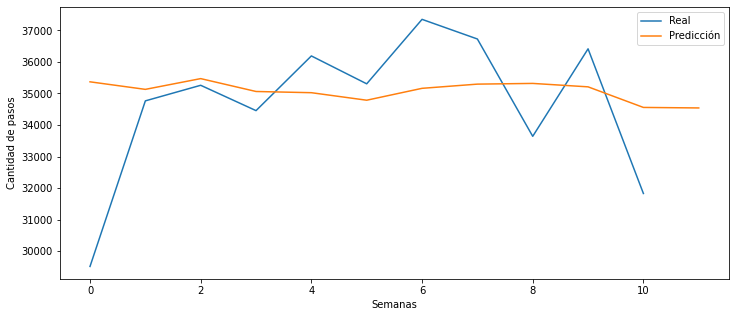

In [187]:
plt.plot(test_ef2.values, label='Real')
plt.plot(inv_yhat[-len(test_ef):], label='Predicción')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Semanas')
plt.legend()
plt.show()

In [188]:
# Error RMSE
y_pred = inv_y
y_true = inv_yhat
rmse_LSTM2 = float(rmse(y_pred, y_true ))
print("Error Redes Neuronales LSTM (RMSE):", rmse_LSTM2)

Error Redes Neuronales LSTM (RMSE): 4120.2119140625


# Resultados Globales

Es importante aclarar que los algoritmos de Redes Neuronales son estocásticos. Esto significa que hacen uso de la aleatoriedad, como la inicialización a pesos aleatorios, y a su vez, la misma red entrenada con los mismos datos puede producir resultados diferentes. Por esta razón hago una transcripción de los resultados obtenidos y sobre los que se toman las conclusiones. 

**Resultados RMSE para el 4to Trimestre 2019 - Illia | Efectivo**


|Modelo         |   RMSE    |
|:--------------|:--------:|
|Benchmark: Random Forest Regressor|2299.31|
|**Prophet**|**1920.81**|
|Neural Prophet|3410.77|
|Neural Prophet con Hiperparametros|3993.30|
|Redes Neuronales MLP      |3647.92|
|Redes Neuronales LSTM|3969.14|

**Resultados RMSE para el 1er Trimestre 2020 - Illia | Efectivo**

|Modelo         |   RMSE    |
|:--------------|:--------:|
|Benchmark: Random Forest Regressor|4864.91|
|Prophet|4795.82|
|Neural Prophet|2477.96|
|**Neural Prophet con Hiperparametros**|**2149.86**|
|Redes Neuronales MLP      |5549.76|
|Redes Neuronales LSTM|4120.21|

In [189]:
# Resultados RMSE para 4to trimestre 2019
resultados_1 = pd.DataFrame(columns=['Modelo', 'RMSE'])
resultados_1['Modelo'] = ['Benchmark (Random Forest)','Prophet','Neural Prophet','Neural Prophet con Hiperparametros','Redes Neuronales MLP','Redes Neuronales LSTM']
resultados_1['RMSE'] = [rmse_bench, rmse_prop_ef, rmse_npr, rmse_nprh, rmse_mlp, rmse_LSTM]
# Resultados RMSE para 1er trimestre 2020
resultados_2 = pd.DataFrame(columns=['Modelo', 'RMSE'])
resultados_2['Modelo'] = ['Benchmark (Random Forest)','Prophet','Neural Prophet','Neural Prophet con Hiperparametros','Redes Neuronales MLP','Redes Neuronales LSTM']
resultados_2['RMSE'] = [rmse_bench2, rmse_prop_ef2, rmse_npr2, rmse_nprh2, rmse_mlp2, rmse_LSTM2]


In [190]:
bold('Resultados RMSE para el 4to Trimestre 2019 - Illia|Efectivo')
resultados_1

Resultados RMSE para el 4to Trimestre 2019 - Illia|Efectivo


,Modelo,RMSE
0,Benchmark (Random Forest),2299.314608
1,Prophet,1920.818097
2,Neural Prophet,3410.778014
3,Neural Prophet con Hiperparametros,3993.309822
4,Redes Neuronales MLP,3647.925855
5,Redes Neuronales LSTM,3969.146729


In [191]:
bold('Resultados RMSE para el 1er Trimestre 2020 - Illia|Efectivo')
resultados_2

Resultados RMSE para el 1er Trimestre 2020 - Illia|Efectivo


,Modelo,RMSE
0,Benchmark (Random Forest),4864.919718
1,Prophet,4795.826609
2,Neural Prophet,2477.960929
3,Neural Prophet con Hiperparametros,2149.861277
4,Redes Neuronales MLP,5549.762392
5,Redes Neuronales LSTM,4120.211914


# Conclusiones

El objetivo de este proyecto era agregar más datos y probar modelos más avanzados de Machine Learning y Deep Learning para comparar con los modelos utilizados en el proyecto anterior. 

Luego del estudio y la aplicación de los modelos elegidos, podemos concluir que los modelos de Prophet y Neural Prophet funcionaron muy bien en este problema de predicción de flujo vehicular. Ambos modelos resultaron muy faciles de utilizar, ya que con pocas configuraciones se obtienen procesos muy potentes que arrojan excelentes resultados. La utilización de recursos computacionales está muy optimizada, lo que hacer que Prophet y Neural Prophet sean modelos muy tentadores a la hora de elegir. 

Con respecto a los modelos de Redes Neuronales, su utilización requiere mayor estudio, aprendizaje y entendimiento que los modelos de Prophet. Además de la complejidad de las Redes Neuronales, también existe una amplia gama de modelos de Redes, cada uno con configuración de hiperparametros y capas, la posibilidad de agregar multivariables y variables externas. Hasta lo que se pudo aplicar en este proyecto, queda la sensación de que son modelos muy potentes y muy versátiles, para aplicar en series temporales y en muchas otras aplicaciones. Aunque requiere un costo de aprendizaje y de recursos computacionales bastante alto. 

La conclusión final de ambos proyectos es que a veces modelos simples o clásicos como ARIMA, Randon Forest y XGBoost pueden dar buenos resultados sin utilizar demasiados recursos y de manera relativamente simple. Los modelos de Deep Learning como son las Redes Neuronales tienen un potencial enorme, y requieren de mucho estudio e investigación para sacarle buen provecho. En todo caso, lo importante es elegir el modelo que se acomode mejor al problema, siempre teniendo en cuenta el costo de aprendizaje y recursos computacionales. 

Personalmente elijo los modelos de Prophet y Neural Prophet que demostraron una gran versatilidad y grandes resultados, siendo muy simples de usar, y con pocos recursos computacionales. Queda pendiente utilizar estos modelos con datasets de granularidad diaria, para poder utilizar al máximo algunos parámetros como estacionalidad y días festivos.


# Links de referencia
[Prophet | Documentación Oficial](https://facebook.github.io/prophet/)

[Forecasting con Prophet](https://medium.com/@angel.r.chicote/forecasting-con-prophet-7fb36b25eb4b)

[Time Series Forecasting With Prophet in Python](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)

[Neural Prophet | Documentación Oficial](https://neuralprophet.com/html/index.html)

[Redes neuronales con Python](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python.html)

[When to Use MLP, CNN, and RNN Neural Networks](https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

[Pronóstico de Series Temporales con Redes Neuronales en Python](https://www.aprendemachinelearning.com/pronostico-de-series-temporales-con-redes-neuronales-en-python/)

[Pronóstico de Ventas con Redes Neuronales – Parte 2](https://www.aprendemachinelearning.com/pronostico-de-ventas-redes-neuronales-python-embeddings/)
